In [ ]:
#一旦不再使用即释放内存垃圾，=1.0 垃圾占用内存大小达到10G时，释放内存垃圾`
!export FLAGS_eager_delete_tensor_gb=1.0
#启用快速垃圾回收策略，不等待cuda kernel 结束，直接释放显存`
!export FLAGS_fast_eager_deletion_mode=1





In [1]:
import sys
sys.path.append('external-libraries')

import json
import emoji
import scipy as sp
import pandas as pd
import numpy as np

from functools import partial
from math import sqrt

from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import StratifiedKFold

from collections import Counter
import os
import sys
import pickle
import gc
import lightgbm as lgb
np.random.seed(369)

import scipy as sp
import matplotlib.pyplot as plt 
import statsmodels.api as sm

import jieba
import re

from collections import Counter
from functools import partial
from math import sqrt
from PIL import Image

from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.metrics import confusion_matrix as sk_cmatrix
import cv2
import pandas as pd
import numpy as np
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from tqdm import tqdm, tqdm_notebook
import paddlehub as hub
# module = hub.Module(name="ernie_skep_sentiment_analysis")
from visualdl import LogWriter
import time
from sklearn import metrics
import paddle.fluid.layers as L

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def convert_to_list(value, n, name, dtype=np.int):


In [7]:
train = pd.read_csv('train.csv')
sortedTrain = train.sort_values(by='clean_text')

In [6]:
train = pd.read_csv("./dataset/train.csv")
test = pd.read_csv("./dataset/test_stage1.csv")
len(train),len(test)

In [ ]:
fake_pic_dir = os.listdir("dataset/rumor_pic/")
true_pic_dir = os.listdir("dataset/truth_pic/")
len(fake_pic_dir), len(true_pic_dir)

(13635, 20461)

In [3]:
(0.8909+0.9283+0.9349+0.8806+0.9247)/5, (0.89+0.90+0.92+0.91+0.92)/5

(0.9118799999999998, 0.908)

** **
### **处理文本的统计特征**

In [4]:
true_text = []
fake_text = []
# for i in range(len(data)):
#     if data["label"][i] == 1:
#         fake_text.append(data["text"][i])
#     else:
#         true_text.append(data["text"][i])


In [5]:
len(true_text),len(fake_text)

(0, 0)

In [ ]:
def stop_word(filepath):
    f = open(filepath,'r').readlines()
    stopwords = {line.strip() for line in f}
    return stopwords

def clean_text(news):
    removeChars = '[\t’ !"#$%&\'()*+,-./:;<=>?@，。?★、…【】《》？“”‘’！[\\]^_`{|}~]+'
    return re.sub(removeChars, "", news)

def compare_news(newsA, newsB):
    if len(newsA)<10 or len(newsB)<10:
        return False
    
    minSameWordNum = 15
    newsAWords = set(jieba.cut(newsA))
    newsBWords = set(jieba.cut(newsB))
    minSameWordNum = min([minSameWordNum, len(newsAWords), len(newsBWords)])
    sameWords = newsAWords & newsBWords
        
    if len(sameWords) < minSameWordNum:
        return False
    else:
        return True

    return False


def remove_same_news():
    sameNewsTrainIdx = []
    NewsIdx = []

    for i in range(train.shape[0]-1):
        newsA = sortedTrain.iloc[i]["text"]
        newsB = sortedTrain.iloc[i+1]["text"]
        NewsIdx.append(sortedTrain.iloc[i:i+1].index[0])
        if compare_news(newsA, newsB):
            sameNewsTrainIdx.append(sortedTrain.iloc[i:i+1].index[0])
    useTrainIdx = list(set(NewsIdx) - set(sameNewsTrainIdx))
    return useTrainIdx

In [ ]:
train["clean_text"] = train.text.apply(clean_text)
sortedTrain = train.sort_values(by='clean_text')
# train["text"] = train.text.apply(emoji.demojize)


In [ ]:
sortedTrain.drop(labels=[3554, 30814])

,id,text,piclist,userGender,userFollowCount,userFansCount,userWeiboCount,userLocation,userDescription,category,label,clean_text
13996,770315c962df81fd9b94d11420775514,【00后大一新生网上散布辱国等极其错误言论？取消大学入学资格！爱国底线不容许践踏！】王栋，2...,NaN,男,415.0,12263.0,3955.0,湖南益阳,共青团益阳市委官方微博,教育考试,0,00后大一新生网上散布辱国等极其错误言论取消大学入学资格爱国底线不容许践踏王栋2000年8月...
11953,934c567481f378bf67780dd6c6df9d78,[0-3岁宝宝禁吃5类食物]3、含过氧化脂质的食物：过氧化脂质会导致大脑早衰或痴呆，直接有损...,a032e68919b9920e20d1ec16c4acc774.jpg,女,194.0,167.0,535.0,广东广州,爱宝宝，从宝宝牙齿健康开始,医药健康,0,03岁宝宝禁吃5类食物3含过氧化脂质的食物：过氧化脂质会导致大脑早衰或痴呆直接有损于大脑的发...
32848,18900525b77a111e52848e6ab8bbb37d,03月30日09时47分在贵州省黔东南苗族侗族自治州剑河县(北纬26.6度，东经108.8度...,518abf2b5f659839a4d59abdd5aedd0d.jpg\tf0915887...,男,321.0,1473.0,347.0,贵州 黔东南,学生、新青年____会当凌绝顶，一览众山小。,社会生活,1,03月30日09时47分在贵州省黔东南苗族侗族自治州剑河县北纬266度东经1088度发生55...
33123,5ed294f4d930db69717f21dac8470beb,04-2012:57帮忙转发一下，一位叫徐敬的女孩，21岁，请速回雅安雨城人民医院，妈妈伤的...,NaN,男,889.0,247.0,408.0,湖北 武汉,高度近视，高度负责，高度喜欢。,社会生活,1,04201257帮忙转发一下一位叫徐敬的女孩21岁请速回雅安雨城人民医院妈妈伤的很严重想见她...
33569,06f0e6c27d8357209f375e7ed55d1eea,04-2022:48:37谁的群最多，帮忙转发一下，一位叫徐敬的女孩，21岁，请速回雅安水城...,NaN,男,179.0,52.0,57.0,河南 郑州,NaN,社会生活,1,0420224837谁的群最多帮忙转发一下一位叫徐敬的女孩21岁请速回雅安水城县人民医院妈妈...
...,...,...,...,...,...,...,...,...,...,...,...,...
13430,6f41d437665178a36f418019d09e5e4d,🚦#小五播报#温馨提示，五里铺十字路口晚高峰道路畅通，过往车辆请注意避让行人，广大驾驶员朋友...,af970ae4b2af822b929f1adf30124f2d.jpg\t096d2add...,男,1052.0,42639.0,34740.0,甘肃兰州,兰州市公安局交通警察支队东岗大队五中队官方微博,社会生活,0,🚦小五播报温馨提示五里铺十字路口晚高峰道路畅通过往车辆请注意避让行人广大驾驶员朋友请稳驾慢行...
4942,34f423a7c8d3f0e881da2400971c8f63,🚦#小五播报#温馨提示，兰州东高速路口早高峰道路畅通，过往车辆请注意避让行人，广大驾驶员朋友...,4e672e37f8cd2256ebf187252b0dc35c.jpg\tc8f16b3f...,男,963.0,43056.0,37386.0,甘肃兰州,兰州市公安局交通警察支队东岗大队五中队官方微博,社会生活,0,🚦小五播报温馨提示兰州东高速路口早高峰道路畅通过往车辆请注意避让行人广大驾驶员朋友请稳驾慢行...
27174,59e2c2fe7961f52f40674a61845180c8,🚫🚫🚫家裡有小孩的～以后给我插头拔掉！！！！！这个小女孩不幸死于电话充电器，就是因为大人平时...,9d9ab3d54bb64f585aa1fae1dbc991d7.jpg,女,198.0,229.0,1251.0,浙江 杭州,这里有大量的麻辣段子，学学这种行走江湖的“毒”门武器吧。。,社会生活,1,🚫🚫🚫家裡有小孩的～以后给我插头拔掉这个小女孩不幸死于电话充电器就是因为大人平时充完电后没有...
33329,dbfb184dcfa8f2a95335bcb00048ccfe,🤔🤔目测真实情况，要多注意才是。妈个鸡！重庆西南医院今天凌晨8点43分，五名男女生感染H7N...,NaN,男,108.0,52.0,95.0,四川,污到最后便是圣人，，,医药健康,1,🤔🤔目测真实情况要多注意才是妈个鸡重庆西南医院今天凌晨8点43分五名男女生感染H7N9病毒死...


In [ ]:
useTrainIdx = remove_same_news()
len(useTrainIdx)

In [ ]:
true_text = []
fake_text = []
sortedTrain = sortedTrain.loc[useTrainIdx]
for idx in useTrainIdx:
    if sortedTrain["label"][idx] == 0:
        true_text.append(sortedTrain["text"][idx])
    else:
        fake_text.append(sortedTrain["text"][idx])

In [ ]:
len(true_text), len(fake_text)

In [ ]:
true_data = sortedTrain[sortedTrain['label'] == 0] 
fake_data = sortedTrain[sortedTrain['label'] == 1] 

In [ ]:
len(true_data), len(fake_data)

#### **新闻文本情绪识别等**

In [ ]:
def cut_sentence(para):
    para = re.sub('([。|！？\?])([^”’])', r"\1\n\2", para)  # 单字符断句符
    para = re.sub('(\.{6})([^”’])', r"\1\n\2", para)  # 英文省略号
    para = re.sub('(\…{2})([^”’])', r"\1\n\2", para)  # 中文省略号
    para = re.sub('([。！？\?][”’])([^，。！？\?])', r'\1\n\2', para)
    para = para.rstrip()  # 段尾如果有多余的\n就去掉它
    return para.split("\n")

from operator import itemgetter

def emotion_classify(texts):
    results = []
    if len(texts)>0:
        results = module.predict_sentiment(texts=texts, use_gpu=True)
    return results


def text_emotion_classify(texts):
    results = []
    positive_probs = 0
    negative_probs = 0
    sentences = cut_sentence(texts)
    results = emotion_classify(texts=sentences)
    if len(results)>0:
        for result in results:
            positive_probs += result['positive_probs']
            negative_probs += result['negative_probs']
        return positive_probs/len(results), negative_probs/len(results)
    else:
        return 0,0



In [ ]:
def get_probs_map(texts):
    PosProbsMap = {}
    NegProbsMap = {}
    for text in texts:
        positive_probs = 0
        negative_probs = 0
        sentences = cut_sentence(text)
        results = emotion_classify(texts=sentences)
        for result in results:
            positive_probs += result['positive_probs']
            negative_probs += result['negative_probs']
        PosProbsMap[text] = positive_probs/len(results)
        NegProbsMap[text] = negative_probs/len(results)
        
    return PosProbsMap,NegProbsMap

In [ ]:
truePosProbsMap, trueNegProbsMap = get_probs_map(true_text)
fakePosProbsMap, fakeNegProbsMap = get_probs_map(fake_text)

In [ ]:
len(truePosProbsMap) + len(fakePosProbsMap), len(sortedTrain)

In [ ]:
sortedTrain["prob"] = sortedTrain["text"].apply(lambda x: text_emotion_classify(x))
sortedTrain[["pos_prob", "neg_prob"]] = sortedTrain["prob"].apply(pd.Series)
sortedTrain[["pos_prob", "neg_prob"]]

In [ ]:
def drow_cdf(sample1, sample2, x=1.0, title="table"):
    ecdf1 = sm.distributions.ECDF(sample1)
    ecdf2 = sm.distributions.ECDF(sample2)
    x = np.linspace(0, x)
    y1 = ecdf1(x)
    y2 = ecdf2(x)
    plt.title(title)
    plt.plot(x, y1,label="true")
    plt.plot(x, y2,label="fake")
    plt.legend()
    plt.show()
    pd.DataFrame({'x':x,'true':y1,'fake':y2}).to_csv(title +'.csv')
    return x, y1, y2

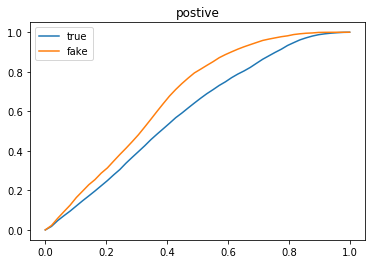

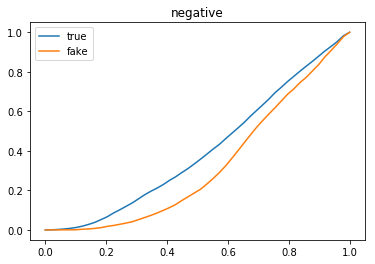

In [ ]:
%matplotlib inline
sortedTrain = pd.read_csv('use_train2.csv')
true_data = sortedTrain[sortedTrain['label'] == 0] 
fake_data = sortedTrain[sortedTrain['label'] == 1] 
true_data.to_csv('true.csv')
fake_data.to_csv('fake.csv')

truePosData = true_data.pos_prob.values
fakePosData = fake_data.pos_prob.values
trueNegData = true_data.neg_prob.values
fakeNegData = fake_data.neg_prob.values

x,y1,y2 = drow_cdf(truePosData,fakePosData, title="postive")
x,y3,y4 = drow_cdf(trueNegData,fakeNegData, title="negative")
pd.DataFrame({0:x,'true':y1,'fake':y2,'true2':y3,'fake2':y4}).to_csv('emotion.csv')

# drow_cdf(trueNegData,"trueNegData")
# drow_cdf(fakeNegData,"fakeNegData")
# plt.show()

# drow_cdf(trueNeuData,"trueNeuData")
# drow_cdf(fakeNeuData,"fakeNeuData")
# plt.show()

(array([0.08225932, 0.4035285 , 0.29553719, ..., 0.40809671, 0.395825  ,
        0.63065654]),)

#### **问号、感叹号数量特征、新闻长度**

In [ ]:
def count_question_mark(text):
    return text.count("?")+text.count("？")

def count_exclamatory_mark(text):
    return text.count("!")+text.count("！")

def count_emoji(text):
    return emoji.emoji_count(text)


def count_syb_lenth(text, l = r"[【].*?[】]"):     
    flag = 0
    titles = re.findall(l, text)
    for title in titles:
        flag += len(title)
    return flag

def count_hash_tag_num(text):
    hashtag = re.findall(r"[#].*?[#]", text)
    return len(hashtag)


def get_mark(texts):
    quesList=[]
    excList=[]
    emojiList=[]
    titleLen = []
    hashTag = []
    hashTagNum = []
    for text in texts:
        quesList.append(count_question_mark(text)/len(text))
        excList.append(count_exclamatory_mark(text)/len(text))
        emojiList.append(count_emoji(text)/len(text))
        titleLen.append(count_syb_lenth(text))
        hashTag.append(count_syb_lenth(text, r"[#].*?[#]"))
        hashTagNum.append(count_hash_tag_num(text))
    return quesList, excList, emojiList, titleLen, hashTag, hashTagNum


In [ ]:
trueQueMap, trueExcMap, trueEmoji, trueTitleLen, trueHashTagLen, trueHashTagNum = get_mark(true_data['text'])
fakeQueMap, fakeExcMap, fakeEmoji, fakeTitleLen, fakeHashTagLen, fakeHashTagNum = get_mark(fake_data['text'])

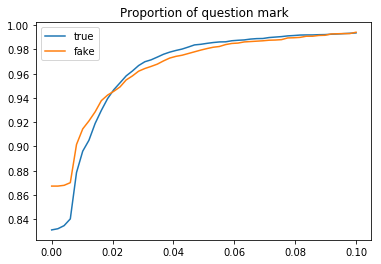

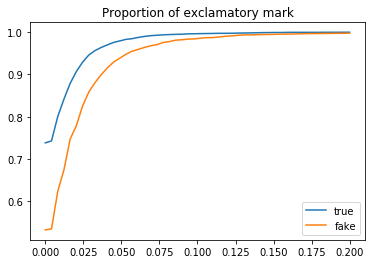

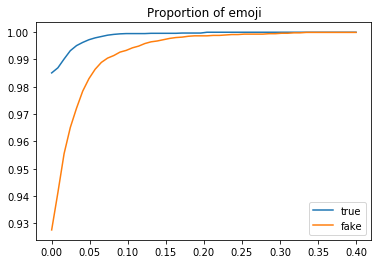

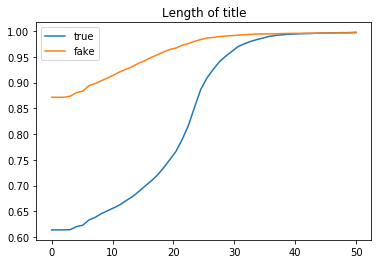

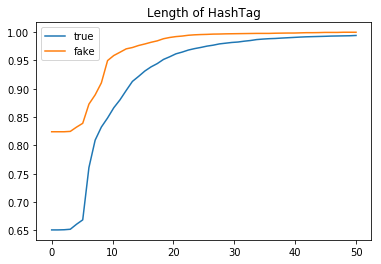

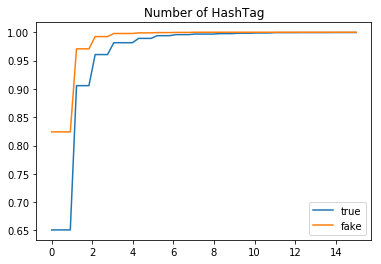

(array([ 0.        ,  0.30612245,  0.6122449 ,  0.91836735,  1.2244898 ,
         1.53061224,  1.83673469,  2.14285714,  2.44897959,  2.75510204,
         3.06122449,  3.36734694,  3.67346939,  3.97959184,  4.28571429,
         4.59183673,  4.89795918,  5.20408163,  5.51020408,  5.81632653,
         6.12244898,  6.42857143,  6.73469388,  7.04081633,  7.34693878,
         7.65306122,  7.95918367,  8.26530612,  8.57142857,  8.87755102,
         9.18367347,  9.48979592,  9.79591837, 10.10204082, 10.40816327,
        10.71428571, 11.02040816, 11.32653061, 11.63265306, 11.93877551,
        12.24489796, 12.55102041, 12.85714286, 13.16326531, 13.46938776,
        13.7755102 , 14.08163265, 14.3877551 , 14.69387755, 15.        ]),
 array([0.65101721, 0.65101721, 0.65101721, 0.65101721, 0.90571205,
        0.90571205, 0.90571205, 0.96058294, 0.96058294, 0.96058294,
        0.98151408, 0.98151408, 0.98151408, 0.98151408, 0.98914319,
        0.98914319, 0.98914319, 0.99393584, 0.99393584, 0.993935

In [ ]:
%matplotlib inline

drow_cdf(trueQueMap, fakeQueMap, 0.1, "Proportion of question mark")
drow_cdf(trueExcMap, fakeExcMap, 0.2, "Proportion of exclamatory mark")
drow_cdf(trueEmoji, fakeEmoji, 0.4, "Proportion of emoji")
drow_cdf(trueTitleLen, fakeTitleLen, 50, "Length of title")
drow_cdf(trueHashTagLen, fakeHashTagLen, 50, "Length of HashTag")
drow_cdf(trueHashTagNum, fakeHashTagNum, 15, "Number of HashTag")


In [ ]:
sortedTrain["question_mark"] = sortedTrain["text"].apply(lambda x: count_question_mark(x)/len(x))
sortedTrain["exclamatory_mark"] = sortedTrain["text"].apply(lambda x: count_exclamatory_mark(x)/len(x))
sortedTrain["emoji_num"] = sortedTrain["text"].apply(lambda x: count_emoji(x)/len(x))
sortedTrain["title_len"] = sortedTrain["text"].apply(lambda x: count_syb_lenth(x))
sortedTrain["hash_tag_len"] = sortedTrain["text"].apply(lambda x: count_syb_lenth(x, r"[【].*?[】]"))
sortedTrain["hash_tag_num"] = sortedTrain["text"].apply(lambda x: count_hash_tag_num(x))
sortedTrain.fillna(-1)

In [ ]:
sortedTrain.columns

In [ ]:
sortedTrain.to_csv("use_train.csv")

In [ ]:
len(sortedTrain), len(sortedTrain2)

#### **图片特征**


In [ ]:
use = ['category', 'clean_text', 'emoji_num', 'exclamatory_mark',
       'exifinfo_count', 'h', 'hash_tag_len', 'hash_tag_num', 'l', 'l*h',
       'l*h-1mean', 'l*h-1median', 'l/h', 'label', 'neg_prob', 'num_url',
       'pic_num', 'piclist', 'pos_prob', 'question_mark', 'size', 'text',
       'title_len', 'userDescription', 'userFansCount', 'userFollowCount',
       'userGender', 'userLocation', 'userWeiboCount']
sortedTrain = sortedTrain[use]
sortedTrain = sortedTrain.fillna(-1)
sortedTrain.head().to_csv("1.csv")
sortedTrain.to_csv("use_train.csv")

In [ ]:
import pandas as pd
sortedTrain = pd.read_csv("use_train.csv")
list(sortedTrain.head(7)["piclist"])

In [ ]:
def pic_num(x):
    if x == "-1":
        return 0
    else:
        num = len(str(x).split("\t"))
        return num

In [ ]:
sortedTrain["pic_num"] = sortedTrain["piclist"].apply(lambda x: pic_num(x))
sortedTrain["pic_num"].mean()

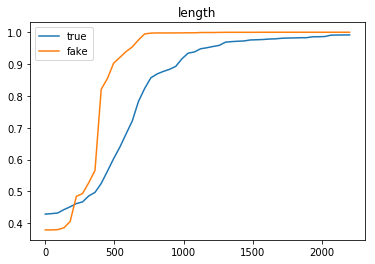

(397.2784157879375, 233.34449690694993)

In [ ]:
true_data = sortedTrain[sortedTrain['label'] == 0] 
fake_data = sortedTrain[sortedTrain['label'] == 1] 

truePicNum = true_data.l.values
fakePicNum = fake_data.l.values


drow_cdf(truePicNum,fakePicNum, 2200, title="length")
np.mean(truePicNum),np.mean(fakePicNum)

In [ ]:
sortedTrain = pd.concat([sortedTrain, pd.DataFrame(columns=['l', 'h', 'size', 'exifinfo_count', 'l*h', 'l/h', 'l*h-1mean', 'l*h-1median'])])

In [ ]:
import cv2
from scipy import fftpack as fftp
import imageio
 
def readImg(im_fn):
    im = cv2.imread(im_fn)
    if im is None :
        print('{} cv2.imread failed'.format(im_fn))
        tmp = imageio.mimread(im_fn)
        if tmp is not None:
            imt = np.array(tmp)
            imt = imt[0]
            im = imt[:,:,0:3]
    return im

def double_compressed(image_path):
    thres = 0.5
    image = readImg(image_path)

    shape = image.shape

    if shape[0] % 8 != 0:
        dct_rows = shape[0] + 8 - shape[0] % 8;
    else:
        dct_rows = shape[0];
    if shape[1] % 8 != 0:
        dct_cols = shape[1] + 8 - shape[1] % 8;
    else:
        dct_cols = shape[1];
    dct_image = np.zeros((dct_rows, dct_cols, 3), np.uint8)
    dct_image[0:shape[0], 0:shape[1]] = image

    y = cv2.cvtColor(dct_image, cv2.COLOR_BGR2YCR_CB)[:, :, 0]

    w = y.shape[1]
    h = y.shape[0]

    Y = y.reshape(h // 8, 8, -1, 8).swapaxes(1, 2).reshape(-1, 8, 8)

    qDCT = []
    for i in range(0, Y.shape[0]):
        qDCT.append(cv2.dct(np.float32(Y[i])))

    qDCT = np.asarray(qDCT, dtype=np.float32)

    qDCT = np.rint(qDCT - np.mean(qDCT, axis=0)).astype(np.int32)
    k = 0
    image_peak_counts = []
    for idx in range(64):
        k += 1
        data = qDCT[:, int(idx / 8), int(idx % 8)]
        val, key = np.histogram(data, bins=np.arange(data.min(), data.max() + 1), normed=True)
        z = np.absolute(fftp.fft(val))
        z = np.reshape(z, (len(z), 1))
        rotz = np.roll(z, int(len(z) / 2))
        slope = rotz[1:] - rotz[:-1]
        indices = [i + 1 for i in range(len(slope) - 1) if slope[i] > 0 and slope[i + 1] < 0]
        peak_count = 0

        for j in indices:
            if rotz[j][0] > thres:
                peak_count += 1
        image_peak_counts.append(peak_count)
    return image_peak_counts


In [ ]:
double_compressed("dataset/truth_pic/4986dc2a5f09a87c7af5dfc57d7775cd.jpg")

In [ ]:
data = []

errorIamge = ["71448fae0e082172abbc9d618533c4ad.jpg"]

lengths, highs, ss, exifinfo_counts = [], [], [], []
for i, row in sortedTrain.iterrows():
    picPath = []
    picName = []
    length, high, s, exifinfo_count, peak_count = 0, 0, 0, 0, 0
    if row["piclist"] == "-1":
        highs.append(0)
        ss.append(0)
        exifinfo_counts.append(0)
        lengths.append(0)
    else:
        picName = row["piclist"].split("\t")
        if row["label"] == 0:
            for path in picName:
                if path not in errorIamge:
                    picPath.append(os.path.join("dataset/truth_pic",path))
        if row["label"] == 1:
            for path in picName:
                if path not in errorIamge:
                    picPath.append(os.path.join("dataset/rumor_pic",path))


        for path in picPath:
            s += os.path.getsize(path)
            img = Image.open(path)

            if hasattr(img, '_getexif'):
                try:
                    exifinfo = img._getexif()
                    if exifinfo != None:
                        exifinfo_count += len(exifinfo)
                except:
                    pass

            l, h = img.size
            length += l
            high += h
        highs.append(high/len(picPath))
        ss.append(s/len(picPath))
        exifinfo_counts.append(exifinfo_count/len(picPath))
        lengths.append(length/len(picPath))

In [ ]:
sortedTrain["l"]=pd.Series(lengths)
sortedTrain["h"]=pd.Series(highs)
sortedTrain["size"]=pd.Series(ss)
sortedTrain["exifinfo_count"]=pd.Series(exifinfo_counts)
sortedTrain.head().to_csv("1.csv")

In [ ]:
len(highs), len(sortedTrain)

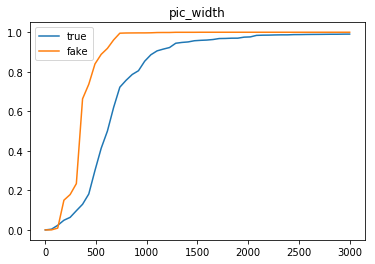

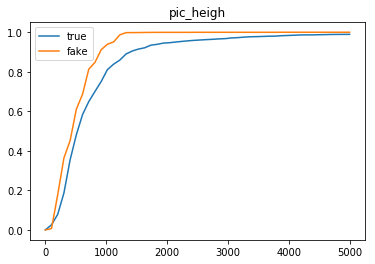

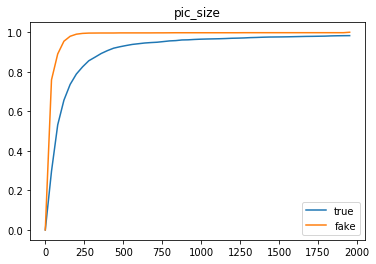

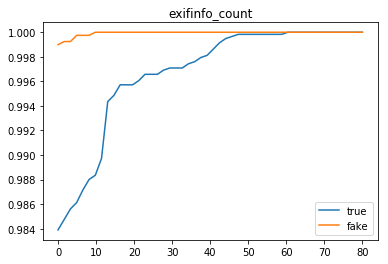

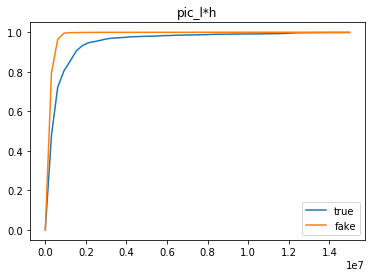

(array([       0.        ,   306122.44897959,   612244.89795918,
          918367.34693878,  1224489.79591837,  1530612.24489796,
         1836734.69387755,  2142857.14285714,  2448979.59183673,
         2755102.04081633,  3061224.48979592,  3367346.93877551,
         3673469.3877551 ,  3979591.83673469,  4285714.28571429,
         4591836.73469388,  4897959.18367347,  5204081.63265306,
         5510204.08163265,  5816326.53061225,  6122448.97959184,
         6428571.42857143,  6734693.87755102,  7040816.32653061,
         7346938.7755102 ,  7653061.2244898 ,  7959183.67346939,
         8265306.12244898,  8571428.57142857,  8877551.02040816,
         9183673.46938775,  9489795.91836735,  9795918.36734694,
        10102040.81632653, 10408163.26530612, 10714285.71428571,
        11020408.16326531, 11326530.6122449 , 11632653.06122449,
        11938775.51020408, 12244897.95918367, 12551020.40816326,
        12857142.85714286, 13163265.30612245, 13469387.75510204,
        13775510.20408163

In [ ]:
true_data = sortedTrain[sortedTrain['label'] == 0] 
fake_data = sortedTrain[sortedTrain['label'] == 1] 

truePicLen = true_data.l.values
fakePicLen = fake_data.l.values
truePicHeigh = true_data.h.values
fakePicHeigh = fake_data.h.values
truePicSize = true_data["size"].values
fakePicSize = fake_data["size"].values
truePicExif = true_data["exifinfo_count"].values
fakePicExif = fake_data["exifinfo_count"].values


drow_cdf(truePicLen,fakePicLen, x=3000, title="pic_width")
drow_cdf(truePicHeigh,fakePicHeigh, x=5000, title="pic_heigh")
drow_cdf(truePicSize/1024,fakePicSize/1024, x=2000000/1024, title="pic_size")
drow_cdf(truePicExif,fakePicExif, x=80 , title="exifinfo_count")
drow_cdf(truePicLen*truePicHeigh,fakePicLen*fakePicHeigh, x=3000*5000, title="pic_l*h")


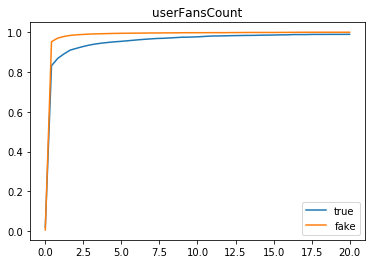

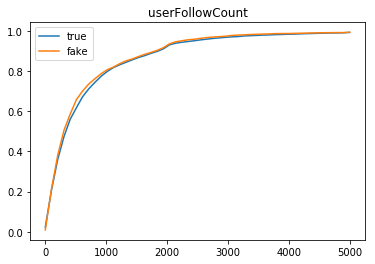

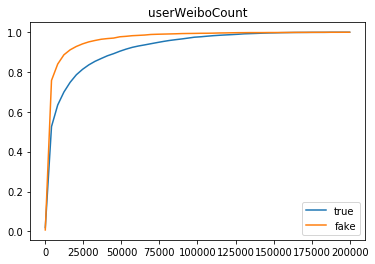

(array([     0.        ,   4081.63265306,   8163.26530612,  12244.89795918,
         16326.53061224,  20408.16326531,  24489.79591837,  28571.42857143,
         32653.06122449,  36734.69387755,  40816.32653061,  44897.95918367,
         48979.59183673,  53061.2244898 ,  57142.85714286,  61224.48979592,
         65306.12244898,  69387.75510204,  73469.3877551 ,  77551.02040816,
         81632.65306122,  85714.28571429,  89795.91836735,  93877.55102041,
         97959.18367347, 102040.81632653, 106122.44897959, 110204.08163265,
        114285.71428571, 118367.34693878, 122448.97959184, 126530.6122449 ,
        130612.24489796, 134693.87755102, 138775.51020408, 142857.14285714,
        146938.7755102 , 151020.40816327, 155102.04081633, 159183.67346939,
        163265.30612245, 167346.93877551, 171428.57142857, 175510.20408163,
        179591.83673469, 183673.46938776, 187755.10204082, 191836.73469388,
        195918.36734694, 200000.        ]),
 array([0.01946401, 0.52552817, 0.63380282, 

In [ ]:
sortedTrain = pd.read_csv('use_train2.csv')

true_data = sortedTrain[sortedTrain['label'] == 0] 
fake_data = sortedTrain[sortedTrain['label'] == 1] 
trueuserFansCount = true_data["userFansCount"].values
fakeuserFansCount = fake_data["userFansCount"].values
trueuserFollowCount = true_data["userFollowCount"].values
fakeuserFollowCount = fake_data["userFollowCount"].values
trueuserWeiboCount = true_data["userWeiboCount"].values
fakeuserWeiboCount = fake_data["userWeiboCount"].values

drow_cdf(trueuserFansCount/1000000,fakeuserFansCount/1000000, x=20, title="userFansCount")
drow_cdf(trueuserFollowCount,fakeuserFollowCount, x=5000, title="userFollowCount")
drow_cdf(trueuserWeiboCount,fakeuserWeiboCount, x=200000, title="userWeiboCount")

In [ ]:
fake_data["userWeiboCount"]

0          641.0
2         2450.0
7           96.0
8         1633.0
10       37919.0
          ...   
16603      628.0
16604     2159.0
16605     1788.0
16606      174.0
16607     1225.0
Name: userWeiboCount, Length: 6384, dtype: float64

In [ ]:
errorIamge = ["71448fae0e082172abbc9d618533c4ad.jpg", "3deb397d5eec692e7b9e08880b264927.gif", "99bceb0f305537eae98b35ec6dd551bb.jpg"]

NullPicDCT = [0]*64
        

In [ ]:
import os
def dct(piclist):
    NullPicDCT = [0]*64
    peak_counts = []
    if piclist == "-1":
        return NullPicDCT
    else:
        picName = piclist.split("\t")[0]
        path = os.path.join("dataset/truth_pic", picName)
        if not os.path.exists(path):
            path = os.path.join("dataset/rumor_pic/", picName)
        try:
            peak_count = double_compressed(path)
            return peak_count
        except Exception as e:
            print(e)
            return NullPicDCT
           
        

In [ ]:
# len(image_peak_counts_total)
sortedTrain["dct"] = sortedTrain["piclist"].apply(lambda x : dct(x))

In [ ]:
sortedTrain["dct"]

In [ ]:
col = ["dct_{}".format(i) for i in range(64)]
sortedTrain[col] = sortedTrain['dct'].apply(pd.Series)

In [ ]:
sortedTrain.head(7).to_csv("1.csv")
sortedTrain.to_csv("use_train2.csv")

In [ ]:
sortedTrain = pd.read_csv('use_train2.csv')

# 图片分类、文字识别

In [ ]:
import requests 

# client_id 为官网获取的AK， client_secret 为官网获取的SK
host = 'https://aip.baidubce.com/oauth/2.0/token?grant_type=client_credentials&client_id=pV74Dh6xTG1z34NtSZDaldrL&client_secret=lBUpfYfU0koAw0RMYwdKE98I8NsnBrLT'
response = requests.get(host)
if response:
    print(response.json())
response.json()['access_token']

In [ ]:
import requests
import base64

'''
通用物体和场景识别
'''

request_url = "https://aip.baidubce.com/rest/2.0/image-classify/v2/advanced_general"
# 二进制方式打开图片文件
f = open('dataset/rumor_pic/100303a3d70e37e6316083eb62f243b9.jpg', 'rb')
img = base64.b64encode(f.read())

params = {"image":img}
access_token = '24.82ad32b21e24cdea169d260760a1fa00.2592000.1616829914.282335-23707557'
request_url = request_url + "?access_token=" + access_token
headers = {'content-type': 'application/x-www-form-urlencoded'}
response = requests.post(request_url, data=params, headers=headers)
if response:
    print (response.json())     

def advanced_general(piclist):
    result = ' '
    if piclist == "-1":
        return result
    else:
        picName = piclist.split("\t")[0]
        try:
            path = os.path.join("dataset/truth_pic", picName)
            if not os.path.exists(path):
                path = os.path.join("dataset/rumor_pic/", picName)
            print(path)
            f = open(path, 'rb')
            img = base64.b64encode(f.read())
            params = {"image":img}
            response = requests.post(request_url, data=params, headers=headers)
            print(response.json()['result_num'])
            
            results = response.json()['result']
            for res in results:
                result += res['keyword']
            return result
        except:
            return ''
        

In [ ]:
len(sortedTrain[sortedTrain['piclist'] == "-1"])

In [ ]:
sortedTrain['general'] = sortedTrain['piclist'].apply(lambda x: advanced_general(x))

In [ ]:
sortedTrain[['text','general']]

In [ ]:
import paddlehub as hub
import cv2
import os
ocr = hub.Module(name="chinese_ocr_db_crnn_server")
# result = ocr.recognize_text(images=[cv2.imread('dataset/rumor_pic/100303a3d70e37e6316083eb62f243b9.jpg')])
def recognize_text(piclist):
    result = ' '
    if piclist == "-1":
        return result
    else:
        picNames = piclist.split("\t")
        paths = []
        try:
            for picName in picNames:
                path = os.path.join("dataset/truth_pic", picName)
                if not os.path.exists(path):
                    path = os.path.join("dataset/rumor_pic/", picName)
                paths.append(readImg(path))
            results = ocr.recognize_text(images=paths, use_gpu=False)
            
            for res in results:
                for data in res['data']:
                    result += data['text']
            return result
        except Exception as e:
            print(e)
            return ''
        

[2021-04-19 14:05:56,628] [ WARNING] - The _initialize method in HubModule will soon be deprecated, you can use the __init__() to handle the initialization of the object


In [ ]:
import re
''.join(re.findall(r'[\u4e00-\u9fa5]', recognize_text("0a06a4dd9fb35263d2ff64813b44902f.jpg")))

'中国联通微信大街上上干的残肢竟然说没有死人光泰达就一千多整个的尸体都没地放了事故死亡人数超过人市委书记这个级别的要被撤职第一批去的武警全部阵亡就多少人三十公里外的都伤那就是这次不是死了人也不是人肯定是人了你长成了详的样子'

In [ ]:
sortedTrain["recognieze_text"] = sortedTrain["piclist"].apply(lambda x : recognize_text(x))

In [ ]:
sortedTrain["recognieze_text"] = sortedTrain['recognieze_text'].apply(lambda a:re.findall(r'[\u4e00-\u9fa5]',a))

In [ ]:
sortedTrain["recognieze_text"] = sortedTrain["recognieze_text"].apply(lambda a: ''.join(a))

In [ ]:
sortedTrain["recognieze_text"]

###   定义model

In [2]:
import paddle.fluid as F
import paddle.nn as nn
from src.model import *
import numpy as np
import paddle
import paddle.fluid as P
import paddle.fluid.dygraph as D
from ernie.tokenizing_ernie import ErnieTokenizer
from ernie.modeling_ernie import *
import ernie


class AttentionLayer(nn.Layer):
    def __init__(self, d_model,  name=None):
        super(AttentionLayer, self).__init__()
        init = nn.initializer.TruncatedNormal(0.02)
        self.d_model = d_model
        d_model_q = d_model
        d_model_v = d_model

        self.d_key = d_model_q
        self.q = nn.Linear(d_model, d_model_q,weight_attr=paddle.ParamAttr(initializer=init))
        self.k = nn.Linear(d_model, d_model_q,weight_attr=paddle.ParamAttr(initializer=init))
        self.v = nn.Linear(d_model, d_model_q,weight_attr=paddle.ParamAttr(initializer=init))
        self.o = nn.Linear(d_model_v, d_model,weight_attr=paddle.ParamAttr(initializer=init))

        self.dropout = nn.Dropout(0.5)

    def forward(self, queries, keys, values):
        assert len(queries.shape) == len(keys.shape) == len(values.shape)
        #bsz, q_len, q_dim = queries.shape
        #bsz, k_len, k_dim = keys.shape
        #bsz, v_len, v_dim = values.shape
        #assert k_len == v_len
        
        q = self.q(queries)
        k = self.k(keys)
        v = self.v(values)

        
        q = q.scale(self.d_key**-0.5)
        score = q.matmul(k, transpose_y=True)
        score = nn.functional.softmax(score)
        score = self.dropout(score)

        out = score.matmul(v)
        return out


class GRU_Attention(nn.Layer):
    def __init__(self, d_vocab, d_emb, init):
        super(GRU_Attention, self).__init__()
        self.d_emb = d_emb
        self.word_emb = nn.Embedding(
            d_vocab,
            d_emb,
            weight_attr=P.ParamAttr(initializer=init))
        self.text_gru = nn.GRU(d_emb, d_emb, num_layers=2, direction='bidirectional')
        self.attention_linear = AttentionLayer(d_emb, 12)
        self.pool = nn.Linear(
            d_emb,
            d_emb,
            weight_attr=P.ParamAttr(initializer=init))
    
    def forward(self, text):
        embedded = self.word_emb(text)
        embedded = nn.LayerNorm(normalized_shape=self.d_emb, weight_attr=P.ParamAttr(initializer=nn.initializer.Constant(1.)),bias_attr=P.ParamAttr(initializer=nn.initializer.Constant(0.)))(embedded)
        embedded = nn.Dropout(0.2)(embedded)
        gru, _ = self.text_gru(embedded)
        att = attention_linear(gru, gru, gru)
        pooled = F.tanh(self.pooler(att[:, 0, :]))

        return pooled


class BPNet(D.Layer):
    def __init__(self, in_dim, n_hidden_1, n_hidden_2,\
                 n_hidden_3, out_dim):
        super(BPNet, self).__init__()
        self.layer1 = nn.Sequential(D.Linear(in_dim, n_hidden_1))
        self.layer2 = nn.Sequential(D.Linear(n_hidden_1, n_hidden_2), nn.BatchNorm(n_hidden_2), nn.LeakyReLU(), nn.Dropout(0.5))
        self.layer3 = nn.Sequential(D.Linear(n_hidden_2, n_hidden_3), nn.BatchNorm(n_hidden_3), nn.LeakyReLU(), nn.Dropout(0.5))
        self.layer6 = nn.Sequential(D.Linear(n_hidden_3, out_dim))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer6(x)
        return x

class FakeNewsNet(D.Layer):
    def __init__(self, cin = 768+768+768+768+128):
        super(FakeNewsNet, self).__init__()
        self.cin = cin
        self.ernie_model = ErnieModel.from_pretrained('ernie-1.0',  num_labels=2)
        # self.ernie_model_cls = ErnieModelForSequenceClassification.from_pretrained('ernie-1.0', num_labels=2)
        # self.img_gru = nn.GRU(768, 300, num_layers=2, direction='bidirectional')
        self.vgg = VGGNet(layers=19)
        self.bp_net1 = BPNet(80, 100,100,100, 128)
        self.init =  nn.initializer.TruncatedNormal(0.02)
        self.classify = D.Linear(cin, 2, dtype='float32', param_attr=paddle.ParamAttr(initializer=self.init))
        # self.hidden = D.Linear(cin, cin, dtype='float32', param_attr=paddle.ParamAttr(initializer=self.init),)

        self.attention_linear1 = AttentionLayer(cin)
        # self.ln1 = nn.LayerNorm(normalized_shape=cin, weight_attr=P.ParamAttr(initializer=nn.initializer.Constant(1.)),bias_attr=P.ParamAttr(initializer=nn.initializer.Constant(0.)))
        # self.ln2 = nn.LayerNorm(normalized_shape=cin, weight_attr=P.ParamAttr(initializer=nn.initializer.Constant(1.)),bias_attr=P.ParamAttr(initializer=nn.initializer.Constant(0.)))
        # self.ffn = nn.Sequential(
        #     D.Linear(cin, 4*cin, dtype='float32', param_attr=paddle.ParamAttr(initializer=self.init)),
        #     nn.Softmax(),
        #     nn.Dropout(0.2),
        #     D.Linear(4*cin, cin, dtype='float32', param_attr=paddle.ParamAttr(initializer=self.init))
        # )



    def forward(self, features, text_ids, pic_ids, image):
        
        # return self.ernie_model_cls(text_ids)
        text_out, _ = self.ernie_model(text_ids)
        # text_out = paddle.nn.functional.leaky_relu(text_out)
        text_out = self.ernie_model.dropout(text_out)

        pic_ids_out, _ = self.ernie_model(pic_ids)
        # pic_ids_out = paddle.nn.functional.leaky_relu(pic_ids_out)
        pic_ids_out = self.ernie_model.dropout(pic_ids_out)


        stat_out = self.bp_net1(features)
        # stat_out = paddle.nn.functional.leaky_relu(stat_out)
        stat_out = nn.Dropout(0.2)(stat_out)
        
        img_out = self.vgg(image)
        # img_out = paddle.nn.functional.softmax(img_out)
        img_out = nn.Dropout(0.5)(img_out)
        
        sim = paddle.abs(text_out - pic_ids_out)
        sim = nn.Dropout(0.5)(sim)
        out = paddle.concat(x=[sim, text_out, pic_ids_out, img_out, stat_out], axis=-1)
        # out = self.ln1(out)
        # att_out =  self.attention_linear1(out, out, out)
        # att_out = nn.Dropout(0.2)(att_out)
        # out = att_out + out
        # out = self.ln1(out)
        # ffn_out = self.ffn(out)
        # ffn_out = nn.Dropout(0.2)(ffn_out) 
        # out = ffn_out + out
        # out = self.ln2(out)
        # out = self.text_gru(text_ids)
        out = nn.BatchNorm(768+768+768+768+128)(out)
        # out =  self.attention_linear1(out, out, out)
        # out = nn.leaky_relu(out)
        out = nn.Dropout(0.2)(out)
        out = self.classify(out)
        return out

In [3]:
import pandas as pd
sortedTrain = pd.read_csv('use_train2.csv')
sortedTrain = sortedTrain[sortedTrain['piclist'] != '-1']
train_data =sortedTrain[['emoji_num', 'exclamatory_mark', 'exifinfo_count', 'h', 'l', 'hash_tag_len', 'hash_tag_num',
       'dct_0', 'dct_1', 'dct_2', 'dct_3', 'dct_4', 
       'dct_5', 'dct_6', 'dct_7', 'dct_8', 'dct_9', 'dct_10', 'dct_11',
       'dct_12', 'dct_13', 'dct_14', 'dct_15', 'dct_16', 'dct_17', 'dct_18',
       'dct_19', 'dct_20', 'dct_21', 'dct_22', 'dct_23', 'dct_24', 'dct_25',
       'dct_26', 'dct_27', 'dct_28', 'dct_29', 'dct_30', 'dct_31', 'dct_32',
       'dct_33', 'dct_34', 'dct_35', 'dct_36', 'dct_37', 'dct_38', 'dct_39',
       'dct_40', 'dct_41', 'dct_42', 'dct_43', 'dct_44', 'dct_45', 'dct_46',
       'dct_47', 'dct_48', 'dct_49', 'dct_50', 'dct_51', 'dct_52', 'dct_53',
       'dct_54', 'dct_55', 'dct_56', 'dct_57', 'dct_58', 'dct_59', 'dct_60',
       'dct_61', 'dct_62', 'dct_63', 'neg_prob', 'num_url', 'pic_num', 'pos_prob',
       'question_mark', 'size', 'title_len','userFansCount','userWeiboCount']]
train_use_data = train_data.fillna(-1)
train_label = sortedTrain['label']

In [ ]:
len(sortedTrain[sortedTrain['label']==0]), len(sortedTrain[sortedTrain['label']==1]), 

(5840, 3963)

In [4]:
sortedTrain = sortedTrain.fillna('')

sortedTrain['pic_text']  = sortedTrain['general'] + sortedTrain['recognieze_text']
sortedTrain['pic_text']

0                                      合照哈利波特与密室扳手腕云水谣狂暴飞车
1                                        人物特写会展屏幕截图沿街店面便利店
5                                           军舰海洋轮船潜艇卡通动漫人物
6         美女女孩抓捕卡通动漫人物合照京乐活北京乐活北京中国移动返回北青社区报顺义版事发地点位于水木...
7                                      人物特写野餐跳蚤市场垃圾堆斗鸡法史论世
                               ...                        
16597     萝卜植物花卉屏幕截图工艺品萍随手拍开工提示大家吃密桃的先用盐水泡以下是家切记吃前热水泡分钟...
16599     屏幕截图书籍文字图病人文字图片微博正文人民日报人民日款来自人民日报微博你好明天天津的大火还...
16601                                     白切羊肉冻货四川腊肉盐水鸭手抓肉
16603        美女丝袜渔网袜腿草帽九二年九月你的英语水平怎样和我的德语水平差不品那你德语水平怎样完全不会
16606                                   屏幕截图人物特写报纸杂志合照人物特写
Name: pic_text, Length: 9803, dtype: object

In [ ]:
sortedTrain = sortedTrain.drop(columns=['l*h','l*h-1mean', 'l*h-1median', 'l/h','Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1',
       'Unnamed: 0.1.1.1.1', ])

In [ ]:
import os
import math
import codecs
import numpy as np
from PIL import Image, ImageEnhance
from src.config import train_parameters


def resize_img(img, target_size):
    """
    强制缩放图片
    :param img:
    :param target_size:
    :return:
    """
    img = img.resize((target_size[1], target_size[2]), Image.BILINEAR)
    return img


def random_crop(img, scale=[0.08, 1.0], ratio=[3. / 4., 4. / 3.]):
    aspect_ratio = math.sqrt(np.random.uniform(*ratio))
    w = 1. * aspect_ratio
    h = 1. / aspect_ratio

    bound = min((float(img.size[0]) / img.size[1]) / (w**2),
                (float(img.size[1]) / img.size[0]) / (h**2))
    scale_max = min(scale[1], bound)
    scale_min = min(scale[0], bound)

    target_area = img.size[0] * img.size[1] * np.random.uniform(scale_min,
                                                                scale_max)
    target_size = math.sqrt(target_area)
    w = int(target_size * w)
    h = int(target_size * h)

    i = np.random.randint(0, img.size[0] - w + 1)
    j = np.random.randint(0, img.size[1] - h + 1)

    img = img.crop((i, j, i + w, j + h))
    img = img.resize((train_parameters['input_size'][1], train_parameters['input_size'][2]), Image.BILINEAR)
    return img


def rotate_image(img):
    """
    图像增强，增加随机旋转角度
    """
    angle = np.random.randint(-14, 15)
    img = img.rotate(angle)
    return img


def random_brightness(img):
    """
    图像增强，亮度调整
    :param img:
    :return:
    """
    prob = np.random.uniform(0, 1)
    if prob < train_parameters['image_enhance_strategy']['brightness_prob']:
        brightness_delta = train_parameters['image_enhance_strategy']['brightness_delta']
        delta = np.random.uniform(-brightness_delta, brightness_delta) + 1
        img = ImageEnhance.Brightness(img).enhance(delta)
    return img


def random_contrast(img):
    """
    图像增强，对比度调整
    :param img:
    :return:
    """
    prob = np.random.uniform(0, 1)
    if prob < train_parameters['image_enhance_strategy']['contrast_prob']:
        contrast_delta = train_parameters['image_enhance_strategy']['contrast_delta']
        delta = np.random.uniform(-contrast_delta, contrast_delta) + 1
        img = ImageEnhance.Contrast(img).enhance(delta)
    return img


def random_saturation(img):
    """
    图像增强，饱和度调整
    :param img:
    :return:
    """
    prob = np.random.uniform(0, 1)
    if prob < train_parameters['image_enhance_strategy']['saturation_prob']:
        saturation_delta = train_parameters['image_enhance_strategy']['saturation_delta']
        delta = np.random.uniform(-saturation_delta, saturation_delta) + 1
        img = ImageEnhance.Color(img).enhance(delta)
    return img


def random_hue(img):
    """
    图像增强，色度调整
    :param img:
    :return:
    """
    prob = np.random.uniform(0, 1)
    if prob < train_parameters['image_enhance_strategy']['hue_prob']:
        hue_delta = train_parameters['image_enhance_strategy']['hue_delta']
        delta = np.random.uniform(-hue_delta, hue_delta)
        img_hsv = np.array(img.convert('HSV'))
        img_hsv[:, :, 0] = img_hsv[:, :, 0] + delta
        img = Image.fromarray(img_hsv, mode='HSV').convert('RGB')
    return img


def distort_color(img):
    """
    概率的图像增强
    :param img:
    :return:
    """
    prob = np.random.uniform(0, 1)
    # Apply different distort order
    if prob < 0.35:
        img = random_brightness(img)
        img = random_contrast(img)
        img = random_saturation(img)
        img = random_hue(img)
    elif prob < 0.7:
        img = random_brightness(img)
        img = random_saturation(img)
        img = random_hue(img)
        img = random_contrast(img)
    return img


def custom_image_reader(piclists):
    """
    自定义用户图片读取器，先初始化图片种类，数量
    :param file_list:
    :param data_dir:
    :param mode:
    :return:
    """
    data = []
    temp = np.zeros(train_parameters['input_size']).astype('float32')
    for piclist in piclists:
        if piclist == '-1':
            data.append(temp)
        else:
            picName = piclist.split('\t')[0]
            path = os.path.join("dataset/truth_pic", picName)
            if not os.path.exists(path):
                path = os.path.join("dataset/rumor_pic/", picName)
        
            img = Image.open(path)

            try:
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                if train_parameters['image_enhance_strategy']['need_distort']:
                    img = distort_color(img)
                if train_parameters['image_enhance_strategy']['need_rotate']:
                    img = rotate_image(img)
                if train_parameters['image_enhance_strategy']['need_crop']:
                    img = random_crop(img, train_parameters['input_size'])
                if train_parameters['image_enhance_strategy']['need_flip']:
                    mirror = int(np.random.uniform(0, 2))
                    if mirror == 1:
                        img = img.transpose(Image.FLIP_LEFT_RIGHT)
                # HWC--->CHW && normalized
                img = np.array(img).astype('float32')
                img -= train_parameters['mean_rgb']
                img = img.transpose((2, 0, 1))  # HWC to CHW
                img /= 255.0                 # 像素值归一化
                data.append(img)
            except Exception as e:
                data.append(temp)
    return data


In [5]:
from src.data import *

tokenizer = ErnieTokenizer.from_pretrained('ernie-1.0')

def encode(text):
    text_id, _ = tokenizer.encode(text) # ErnieTokenizer 会自动添加ERNIE所需要的特殊token，如[CLS], [SEP]
    text_id = text_id[:200]
    text_id = np.pad(text_id, [0, 200-len(text_id)], mode='constant') # 对所有句子都补长至200，这样会比较费显存；
    return text_id

def make_data():
    data = []
    text_ids = []
    pic_text_ids = []
    for text in sortedTrain['clean_text']:
        text_id = encode(text)
        text_id = np.array(text_id)
        text_ids.append(text_id)
    for text in sortedTrain['pic_text']:
        text_id = encode(text)
        text_id = np.array(text_id)
        pic_text_ids.append(text_id)


    text_ids = np.array(text_ids).astype('int64')
    feas = np.array(train_use_data).astype('float32')
    imgs = custom_image_reader(sortedTrain['piclist'])
    # imgs = [0] * len(sortedTrain['clean_text'])
    labels = np.array(train_label).astype('float32')
    for fea, text_id,pic_ids, img, label in zip(feas, text_ids, pic_text_ids,imgs,labels):
        fea_id = np.array(fea)
        img = np.array(img)
        text_id = np.array(text_id)
        pic_ids = np.array(pic_ids)
        label_id = np.array(label)
        data.append((fea_id, text_id, pic_ids, img, label_id))
    return np.array(data)


def get_batch_data(data, i):
    d = data[i*BATCH: (i + 1) * BATCH]
    feature, text_id,pic_ids, img, label = zip(*d)
    feature = np.stack(feature)  # 将BATCH行样本整合在一个numpy.array中
    text_id = np.stack(text_id)
    
    pic_ids = np.stack(pic_ids)
    img = np.stack(img)
    label = np.stack(list(label))
    feature = D.to_variable(feature).astype('float32') # 使用to_variable将numpy.array转换为paddle tensor
    text_id = D.to_variable(text_id).astype('int64') # 使用to_variable将numpy.array转换为paddle tensor
    pic_ids = D.to_variable(pic_ids).astype('int64')
    img = D.to_variable(img).astype('float32')
    label = D.to_variable(label).astype('int64')
    return feature,text_id, pic_ids, img, label


2021-05-11 18:18:40,043 - INFO - get pretrain dir from https://ernie-github.cdn.bcebos.com/model-ernie1.0.1.tar.gz
[INFO 2021-05-11 18:18:40,043 tokenizing_ernie.py:100] get pretrain dir from https://ernie-github.cdn.bcebos.com/model-ernie1.0.1.tar.gz
downloading https://ernie-github.cdn.bcebos.com/model-ernie1.0.1.tar.gz: 788478KB [00:13, 60008.82KB/s]                            


In [6]:
all_data = make_data()
np.random.shuffle(all_data)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:


BATCH=30
place=fluid.CUDAPlace(0)
D.guard(place=place).__enter__()
np.random.shuffle(all_data)
model = FakeNewsNet()
test_data = all_data[:(len(all_data)) // 5]
eval_data = all_data[-(len(all_data)) // 5:]
train_data = all_data[(len(all_data)) // 5:-(len(all_data)) // 5]
criterion = nn.CrossEntropyLoss()
optimizer = paddle.fluid.optimizer.Adam(5e-5,parameter_list=model.parameters())
best_validate_acc = 0.000
best_test_acc = 0.000
best_loss = 100
best_validate_dir = ''
best_list = [0, 0]
with fluid.dygraph.guard():
    with LogWriter(logdir="logs/log-fnn") as writer:
        print('training model')
        adversarial = True
        cnt = 0
        cnt2 = 0
        for epoch in range(100):
            np.random.shuffle(train_data)
            p = float(epoch) / 100
            # lambd = 2. / (1. + np.exp(-10. * p)) - 1
            # lr = 0.001 / (1. + 10 * p) ** 0.75

            # optimizer.lr = lr
            # rgs.lambd = lambd
            start_time = time.time()
            cost_vector = []
            class_cost_vector = []
            domain_cost_vector = []
            acc_vector = []
            valid_acc_vector = []
            test_acc_vector = []
            vali_cost_vector = []
            test_cost_vector = []
            for j in range(len(train_data) // BATCH):
                model.train()
                feature, text_id, pic_ids, img, train_labels = get_batch_data(train_data, j)
                if len(train_labels.shape) == 1:
                        train_labels = paddle.fluid.layers.reshape(train_labels, [-1, 1])

                # Forward + Backward + Optimize
                class_outputs = model(feature, text_id, pic_ids, img)

                
                loss = L.softmax_with_cross_entropy(class_outputs, train_labels)
                loss = L.reduce_mean(loss)
                loss.backward()
                optimizer.minimize(loss)
                model.clear_gradients()
                argmax = paddle.fluid.layers.argmax(class_outputs, -1)


                accuracy = metrics.accuracy_score(train_labels.numpy().astype('int64'), argmax.numpy().astype('int64'))


                class_cost_vector.append(loss.numpy())
                
                cost_vector.append(loss.numpy())
                acc_vector.append(accuracy)
                writer.add_scalar(tag="train-acc", step=cnt, value=accuracy)
                writer.add_scalar(tag="train-loss", step=cnt, value=loss.numpy())
                cnt+=1
                if j%50==0:
                    print('Epoch [%d/%d],batch: %d  Loss: %.4f, Train_Acc: %.4f,'
                % (
                    epoch + 1, 100, j ,loss.numpy(), accuracy))

                
            with D.base._switch_tracer_mode_guard_(is_train=False):
                model.eval()

                validate_acc_vector_temp = []
                for j in range(len(eval_data) // BATCH):
                    feature, text_id, pic_ids, img, validate_labels = get_batch_data(eval_data, j)
                    if len(validate_labels.shape) == 1:
                            validate_labels = paddle.fluid.layers.reshape(validate_labels, [-1, 1])
                    validate_outputs = model(feature, text_id, pic_ids, img)
                    validate_argmax = paddle.fluid.layers.argmax(validate_outputs, -1)
                    vali_loss = L.softmax_with_cross_entropy(validate_outputs, validate_labels)
                    vali_loss = L.reduce_mean(vali_loss)
                    
                    validate_accuracy = metrics.accuracy_score(validate_labels.numpy().astype('int64'), validate_argmax.numpy().astype('int64'))

                    vali_cost_vector.append(vali_loss.numpy())
                    validate_acc_vector_temp.append(validate_accuracy)
                    writer.add_scalar(tag="eval-acc", step=cnt2, value=validate_accuracy)
                    writer.add_scalar(tag="eval-loss", step=cnt2, value=vali_loss.numpy())
                    cnt2+=1

                validate_acc = np.mean(validate_acc_vector_temp)
                valid_acc_vector.append(validate_acc)
                model.train()
                print('Epoch [%d/%d],  Loss: %.4f, Train_Acc: %.4f,  Validate_Acc: %.4f.'
                    % (
                        epoch + 1, 100, np.mean(cost_vector),
                        np.mean(acc_vector), validate_acc))

                if validate_acc > best_validate_acc:
                    best_validate_acc = validate_acc
                    if not os.path.exists('model/'):
                        os.mkdir('model/')

                    best_validate_dir = 'model/fnn/' + str(epoch + 1)
                    D.save_dygraph(model.state_dict(), best_validate_dir)

                duration = time.time() - start_time
                print ('Epoch: %d, Mean_Cost: %.4f, Duration: %.4f, Mean_Train_Acc: %.4f, Mean_vail_Acc: %.4f'
                % (epoch + 1, np.mean(cost_vector), duration, np.mean(acc_vector), np.mean(valid_acc_vector)))
        with D.base._switch_tracer_mode_guard_(is_train=False):
            # Test the Model
            print('testing model')
            model = CNN_Fusion()
            model_dict, _ = paddle.fluid.load_dygraph(best_validate_dir)
            model.load_dict(model_dict)
            #    print(torch.cuda.is_available())
            model.eval()
            test_score = []
            test_pred = []
            test_true = []
            for j in range(len(test_data) // BATCH):
                feature, text_id, pic_ids, img, test_labels = get_batch_data(test_data, j)
                if len(test_labels.shape) == 1:
                    test_labels = paddle.fluid.layers.reshape(test_labels, [-1, 1])

                test_outputs = model(feature, text_id, pic_ids, img)
                test_argmax = paddle.fluid.layers.argmax(test_outputs, -1)
                if j == 0:
                    test_score = test_outputs.squeeze().numpy()
                    test_pred = test_argmax.squeeze().numpy()
                    test_true = test_labels.squeeze().numpy()
                else:
                    test_score = np.concatenate((test_score, test_outputs.squeeze().numpy()), axis=0)
                    test_pred = np.concatenate((test_pred, test_argmax.squeeze().numpy()), axis=0)
                    test_true = np.concatenate((test_true, test_labels.squeeze().numpy()), axis=0)

            test_accuracy = metrics.accuracy_score(test_true, test_pred)
            test_f1 = metrics.f1_score(test_true, test_pred, average='macro')
            test_precision = metrics.precision_score(test_true, test_pred, average='macro')
            test_recall = metrics.recall_score(test_true, test_pred, average='macro')
            test_score_convert = [x[1] for x in test_score]
            test_aucroc = metrics.roc_auc_score(test_true, test_score_convert, average='macro')

            test_confusion_matrix = metrics.confusion_matrix(test_true, test_pred)

            print("Classification Acc: %.4f, AUC-ROC: %.4f"
                % (test_accuracy, test_aucroc))
            print("Classification report:\n%s\n"
                % (metrics.classification_report(test_true, test_pred,digits=4)))
            print("Classification confusion matrix:\n%s\n"
                % (test_confusion_matrix))

2021-05-07 21:30:43,880 - INFO - get pretrain dir from https://ernie-github.cdn.bcebos.com/model-ernie1.0.1.tar.gz
[INFO 2021-05-07 21:30:43,880 modeling_ernie.py:236] get pretrain dir from https://ernie-github.cdn.bcebos.com/model-ernie1.0.1.tar.gz
2021-05-07 21:30:43,983 - INFO - loading pretrained model from /home/aistudio/.paddle-ernie-cache/466eabcffd6d6a83ae9cb97dd1a167bd
[INFO 2021-05-07 21:30:43,983 modeling_ernie.py:254] loading pretrained model from /home/aistudio/.paddle-ernie-cache/466eabcffd6d6a83ae9cb97dd1a167bd


SystemError: (Fatal) Operator uniform_random raises an paddle::memory::allocation::BadAlloc exception.
The exception content is
:ResourceExhaustedError: 

Out of memory error on GPU 0. Cannot allocate 392.000244MB memory on GPU 0, available memory is only 272.500000MB.

Please check whether there is any other process using GPU 0.
1. If yes, please stop them, or start PaddlePaddle on another GPU.
2. If no, please decrease the batch size of your model. 

 (at /paddle/paddle/fluid/memory/allocation/cuda_allocator.cc:69)
. (at /paddle/paddle/fluid/imperative/tracer.cc:172)


In [ ]:
c0 = 0
c1 = 0
for feature, text_id, pic_ids, img, test_labels in train_eval:
    if test_labels == 0:
        c0+=1
    else:
        c1  +=1
c0, c1

(4643, 3200)

In [7]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5,shuffle=True)
def get_train_eval(all_data, rate=1):
    x = []
    a,b=0,0
    if rate<1.5:
        true = int(fake_num*rate)
        fake = fake_num
    else:
        true = true_num
        fake = int(true_num/rate)
    for feature, text_id, pic_ids, img, test_labels in all_data:
        if test_labels==0:
            if a<true:
                x.append((feature, text_id, pic_ids, img, test_labels))
                a+=1
        else:
            if b<fake:
                x.append((feature, text_id, pic_ids, img, test_labels))
                b+=1
    return np.array(x)

true_num = 0
fake_num = 0
for feature, text_id, pic_ids, img, test_labels in all_data:
    if test_labels == 0:
        true_num+=1
    else:
        fake_num  +=1

# train_eval = get_train_eval(all_data[(len(all_data))//10:],5)
train_eval = all_data[(len(all_data))//5:] 
test_data = all_data[:(len(all_data))//5]



train_eval.shape

(7843, 5)

In [8]:
def draw_train_loss(Batchs, eval_acc,eval_loss):
    title="training-eval loss"
    plt.title(title, fontsize=24)
    plt.xlabel("batch", fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.plot(Batchs, eval_acc, color='red', label='eval acc')
    plt.plot(Batchs, eval_loss, color='g', label='eval loss')
    plt.legend()
    plt.grid()
    plt.show()

def test(model, data, i, path):
    model.eval()
    all_pred, all_label, all_score = [], [], []
    if os.path.exists(path+str(i) + '_bestmodel.pdparams'):
        model_dict, _= fluid.load_dygraph(path+str(i) + '_bestmodel.pdparams')
        model.load_dict(model_dict)
    for k in range(len(data) // BATCH):
        feature, text_id, pic_ids, img, label = get_batch_data(data, k)
        predict = model(feature, text_id, pic_ids, img) 
        all_score.extend(predict.numpy())
        predict = L.argmax(predict, -1)
        all_pred.extend(predict.numpy())
        all_label.extend(label.numpy())
        
    model.train()
    test_accuracy = metrics.accuracy_score(all_label, all_pred)
    test_f1 = metrics.f1_score(all_label, all_pred, average='macro')
    test_precision = metrics.precision_score(all_label, all_pred, average='macro')
    test_recall = metrics.recall_score(all_label, all_pred, average='macro')
    test_score_convert = [x[1] for x in all_score]
    test_aucroc = metrics.roc_auc_score(all_label, test_score_convert, average='macro')

    test_confusion_matrix = metrics.confusion_matrix(all_label, all_pred)

    print("Classification Acc: %.4f, AUC-ROC: %.4f"
        % (test_accuracy, test_aucroc))
    print("Classification report:\n%s\n"
        % (metrics.classification_report(all_label, all_pred, digits=4)))
    print("Classification confusion matrix:\n%s\n"
        % (test_confusion_matrix))
    return accuracy_score(all_label, all_pred), f1_score(all_label, all_pred), precision_score(all_label, all_pred), recall_score(all_label, all_pred)

In [ ]:
test_data.shape

(980, 5)

In [9]:
from 
from paddle import fluid
import paddle.fluid.layers as L
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


BATCH= 16
MAX_SEQLEN=150
LR=5e-5
EPOCH=30
   

place=fluid.CUDAPlace(0)
D.guard(place=place).__enter__() # 为了让Paddle进入动态图模式，需要添加这一行在最前面

path = 'all/'
with fluid.dygraph.guard():
    for index, (train_index, eval_index) in enumerate(kf.split(range(len(train_eval)))):
    
        with LogWriter(logdir="logs/log"+str(index)) as writer:
            model = FakeNewsNet()
            if os.path.exists(path+str(index) + '_bestmodel.pdparams'):
                model_dict, _= fluid.load_dygraph(path + str(index) + '_bestmodel.pdparams')
                model.load_dict(model_dict)
                print('load model')
            optimizer = fluid.optimizer.Adam(LR, parameter_list=model.parameters())
            loss_ = nn.BCELoss()
            all_train_iters = []
            all_train_costs = []
            all_train_accs = []
            all_eval_costs = []
            all_eval_accs = []
            best_test_acc = 0
            early_stop = 0
            # print('train_indx',train_index)
            # print('eval_index',eval_index)
            train_data = train_eval[train_index]
            eval_data = train_eval[eval_index]
            cnt = 0
            cnt2 = 0
            for i in range(EPOCH): 
                np.random.shuffle(train_data)  # 每个epoch都shuffle数据以获得最佳训练效果；
                # train
                for j in range(len(train_data) // BATCH):
                    
                    model.train()
                    feature, text_id, pic_ids, img, label = get_batch_data(train_data, j)
                    if len(label.shape) == 1:
                        label = L.reshape(label, [-1, 1])
                    # print(feature, label)
                    predict = model(feature, text_id, pic_ids, img)
                
                    loss = L.softmax_with_cross_entropy(predict, label)
                    loss = L.reduce_mean(loss)
                    predict = L.argmax(predict, -1)
                    acc = accuracy_score(label.numpy().astype('int64'), predict.numpy().astype('int64'))
                    
                    loss.backward()
                    optimizer.minimize(loss)
                    model.clear_gradients()
                    all_train_costs.append(loss.numpy())
                    all_train_accs.append(acc)

            
                    
            
                    if j  % 10 == 0:
                        acc_mean = np.mean(all_train_accs)
                        loss_mean = np.mean(all_train_costs)
                        writer.add_scalar(tag="train-acc", step=cnt, value=acc_mean)
                        writer.add_scalar(tag="train-loss", step=cnt, value=loss_mean)
                        print(index, 'train %d: acc:%.5f , loss: %.5f' % (j, acc_mean, loss_mean))
                        all_train_accs = []
                        all_train_costs = []
                        cnt += 1
                    # evaluate
                    
                    if j % 100 == 0:
                        all_train_costs.append(loss.numpy()[0])
                        all_train_accs.append(acc)
                        with fluid.dygraph.guard():
                            all_pred, all_label = [], []
                            with D.base._switch_tracer_mode_guard_(is_train=False):  # 在这个with域内ernie不会进行梯度计算；
                                model.eval()  # 控制模型进入eval模式，这将会关闭所有的dropout；
                                for k in range(len(eval_data) // BATCH):
                                    feature, text_id, pic_ids, img, label = get_batch_data(eval_data, k)
                                    if len(label.shape) == 1:
                                        label = L.reshape(label, [-1, 1])
                                    predict = model(feature, text_id, pic_ids, img)
                                    loss = L.softmax_with_cross_entropy(predict, label)
                                    loss = L.reduce_mean(loss)
                                    predict = L.argmax(predict, -1)
                                    acc = accuracy_score(label.numpy(), predict.numpy())

                                    writer.add_scalar(tag="eval-acc", step=cnt2, value=acc)
                                    writer.add_scalar(tag="eval-loss", step=cnt2, value=loss.numpy())
                                    cnt2 += 1

                                    all_pred.extend(predict.numpy())
                                    all_label.extend(label.numpy()) 
                                model.train()
                            acc = accuracy_score(all_label, all_pred)
                            all_eval_accs.append(acc)
                            all_eval_costs.append(loss.numpy()[0])
                            print(index, 'eval %d：acc: %.5f' % (j, acc))
                            
                        if acc > best_test_acc:
                            flag = 1
                            early_stop = 0
                            best_test_acc = acc
                            D.save_dygraph(model.state_dict(), path + str(index) + '_bestmodel')
                            print('save model to ' + path + str(index) + '_bestmodel')
                        else:
                            early_stop += 1
                            if early_stop == 10:
                                print(f'early_stop')
                                flag = 0
                                break

                if flag == 0:
                    break
                            
        # draw_train_loss(list(range(len(all_eval_accs))),all_eval_accs,all_eval_costs)
        print('test metrics',test(model, test_data, index, path))
    

2021-05-11 18:24:55,467 - INFO - get pretrain dir from https://ernie-github.cdn.bcebos.com/model-ernie1.0.1.tar.gz
[INFO 2021-05-11 18:24:55,467 modeling_ernie.py:236] get pretrain dir from https://ernie-github.cdn.bcebos.com/model-ernie1.0.1.tar.gz
2021-05-11 18:24:59,393 - INFO - loading pretrained model from /home/aistudio/.paddle-ernie-cache/466eabcffd6d6a83ae9cb97dd1a167bd
[INFO 2021-05-11 18:24:59,393 modeling_ernie.py:254] loading pretrained model from /home/aistudio/.paddle-ernie-cache/466eabcffd6d6a83ae9cb97dd1a167bd


load model
0 train 0: acc:1.00000 , loss: 0.00000
0 eval 0：acc: 0.96173
save model to all/0_bestmodel


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


0 train 10: acc:0.86364 , loss: 6.71076
0 train 20: acc:0.82500 , loss: 11.55216
0 train 30: acc:0.74375 , loss: 13.89836
0 train 40: acc:0.80625 , loss: 9.79063
0 train 50: acc:0.89375 , loss: 8.66759
0 train 60: acc:0.82500 , loss: 10.18035
0 train 70: acc:0.94375 , loss: 3.06535
0 train 80: acc:0.92500 , loss: 3.64020
0 train 90: acc:0.88125 , loss: 6.92944
0 train 100: acc:0.90000 , loss: 5.35962
0 eval 100：acc: 0.91837


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


0 train 110: acc:0.87500 , loss: 7.04333
0 train 120: acc:0.86250 , loss: 8.95643
0 train 130: acc:0.86875 , loss: 6.66552
0 train 140: acc:0.85000 , loss: 6.14995
0 train 150: acc:0.88750 , loss: 8.38313
0 train 160: acc:0.88750 , loss: 6.93903
0 train 170: acc:0.91250 , loss: 5.24500
0 train 180: acc:0.90000 , loss: 9.39562
0 train 190: acc:0.88125 , loss: 8.52633
0 train 200: acc:0.80000 , loss: 11.68905
0 eval 200：acc: 0.90115


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


0 train 210: acc:0.84659 , loss: 6.93120
0 train 220: acc:0.86875 , loss: 10.44398
0 train 230: acc:0.85625 , loss: 7.82213
0 train 240: acc:0.86250 , loss: 6.11715
0 train 250: acc:0.75625 , loss: 11.92994
0 train 260: acc:0.78750 , loss: 13.91781
0 train 270: acc:0.89375 , loss: 2.71723
0 train 280: acc:0.85625 , loss: 10.41266
0 train 290: acc:0.85000 , loss: 7.15961
0 train 300: acc:0.91875 , loss: 8.05273
0 eval 300：acc: 0.90625


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


0 train 310: acc:0.81818 , loss: 12.17740
0 train 320: acc:0.85625 , loss: 8.94855
0 train 330: acc:0.83125 , loss: 11.52878
0 train 340: acc:0.83750 , loss: 9.98694
0 train 350: acc:0.91875 , loss: 4.15227
0 train 360: acc:0.91875 , loss: 4.88848
0 train 370: acc:0.82500 , loss: 13.35200
0 train 380: acc:0.84375 , loss: 8.15442
0 train 390: acc:0.82500 , loss: 9.50677
0 train 0: acc:0.90625 , loss: 2.86895
0 eval 0：acc: 0.92921


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


0 train 10: acc:0.91477 , loss: 2.75210
0 train 20: acc:0.92500 , loss: 2.85265
0 train 30: acc:0.90000 , loss: 6.59720
0 train 40: acc:0.86250 , loss: 8.14195
0 train 50: acc:0.86250 , loss: 5.42494
0 train 60: acc:0.88750 , loss: 7.61934
0 train 70: acc:0.88750 , loss: 7.29026
0 train 80: acc:0.95625 , loss: 2.28333
0 train 90: acc:0.90000 , loss: 4.10322
0 train 100: acc:0.90000 , loss: 8.05089
0 eval 100：acc: 0.94707


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


0 train 110: acc:0.94318 , loss: 3.23712
0 train 120: acc:0.92500 , loss: 3.89166
0 train 130: acc:0.91250 , loss: 7.74224
0 train 140: acc:0.85625 , loss: 7.32213
0 train 150: acc:0.83750 , loss: 5.85614
0 train 160: acc:0.91875 , loss: 3.80258
0 train 170: acc:0.90625 , loss: 3.95627
0 train 180: acc:0.92500 , loss: 7.39109
0 train 190: acc:0.93750 , loss: 5.41770
0 train 200: acc:0.91875 , loss: 4.98788
0 eval 200：acc: 0.94962


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


0 train 210: acc:0.89205 , loss: 9.25913
0 train 220: acc:0.85625 , loss: 7.48478
0 train 230: acc:0.88125 , loss: 6.87426
0 train 240: acc:0.92500 , loss: 8.44191
0 train 250: acc:0.93750 , loss: 3.22229
0 train 260: acc:0.89375 , loss: 6.58334
0 train 270: acc:0.94375 , loss: 2.77908
0 train 280: acc:0.85000 , loss: 10.54834
0 train 290: acc:0.95000 , loss: 3.22112
0 train 300: acc:0.94375 , loss: 3.79042
0 eval 300：acc: 0.94515


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


0 train 310: acc:0.93750 , loss: 5.71551
0 train 320: acc:0.90000 , loss: 7.17982
0 train 330: acc:0.94375 , loss: 4.52270
0 train 340: acc:0.88125 , loss: 8.20059
0 train 350: acc:0.87500 , loss: 7.05381
0 train 360: acc:0.88750 , loss: 5.96409
0 train 370: acc:0.93125 , loss: 5.92732
0 train 380: acc:0.90000 , loss: 4.03284
0 train 390: acc:0.92500 , loss: 4.17077
0 train 0: acc:0.96875 , loss: 3.93308
0 eval 0：acc: 0.95472


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


0 train 10: acc:0.95455 , loss: 3.66903
0 train 20: acc:0.90000 , loss: 4.98685
0 train 30: acc:0.95000 , loss: 2.36682
0 train 40: acc:0.91875 , loss: 4.17063
0 train 50: acc:0.93125 , loss: 2.28085
0 train 60: acc:0.89375 , loss: 4.41151
0 train 70: acc:0.88750 , loss: 3.55651
0 train 80: acc:0.92500 , loss: 3.94031
0 train 90: acc:0.96875 , loss: 3.23707
0 train 100: acc:0.96875 , loss: 1.80067
0 eval 100：acc: 0.95344


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


0 train 110: acc:0.93182 , loss: 4.80222
0 train 120: acc:0.93750 , loss: 4.03948
0 train 130: acc:0.91875 , loss: 5.89167
0 train 140: acc:0.88125 , loss: 8.00724
0 train 150: acc:0.95000 , loss: 4.13920
0 train 160: acc:0.90000 , loss: 3.89605
0 train 170: acc:0.93125 , loss: 8.67157
0 train 180: acc:0.91250 , loss: 8.78354
0 train 190: acc:0.88125 , loss: 7.74019
0 train 200: acc:0.88125 , loss: 7.25162
0 eval 200：acc: 0.89222
early_stop
Classification Acc: 0.9175, AUC-ROC: 0.9604
Classification report:
              precision    recall  f1-score   support

           0     0.9549    0.9076    0.9307      1191
           1     0.8659    0.9330    0.8982       761

    accuracy                         0.9175      1952
   macro avg     0.9104    0.9203    0.9144      1952
weighted avg     0.9202    0.9175    0.9180      1952


Classification confusion matrix:
[[1081  110]
 [  51  710]]

test metrics (0.9175204918032787, 0.8981657179000632, 0.8658536585365854, 0.9329829172141918)


2021-05-11 18:36:31,156 - INFO - get pretrain dir from https://ernie-github.cdn.bcebos.com/model-ernie1.0.1.tar.gz
[INFO 2021-05-11 18:36:31,156 modeling_ernie.py:236] get pretrain dir from https://ernie-github.cdn.bcebos.com/model-ernie1.0.1.tar.gz
2021-05-11 18:36:31,243 - INFO - loading pretrained model from /home/aistudio/.paddle-ernie-cache/466eabcffd6d6a83ae9cb97dd1a167bd
[INFO 2021-05-11 18:36:31,243 modeling_ernie.py:254] loading pretrained model from /home/aistudio/.paddle-ernie-cache/466eabcffd6d6a83ae9cb97dd1a167bd


1 train 0: acc:0.62500 , loss: 16.44760
1 eval 0：acc: 0.47194
save model to all/1_bestmodel
1 train 20: acc:0.55625 , loss: 25.07730
1 train 30: acc:0.53125 , loss: 31.97833
1 train 40: acc:0.65625 , loss: 20.30391
1 train 50: acc:0.61250 , loss: 20.07262
1 train 60: acc:0.66250 , loss: 15.32587
1 train 70: acc:0.76875 , loss: 14.78998
1 train 80: acc:0.65000 , loss: 18.60612
1 train 90: acc:0.68125 , loss: 17.13288
1 train 100: acc:0.70000 , loss: 19.23687
1 eval 100：acc: 0.71875
save model to all/1_bestmodel


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


1 train 110: acc:0.69318 , loss: 17.14738
1 train 130: acc:0.65000 , loss: 16.75557
1 train 140: acc:0.71875 , loss: 17.58219
1 train 150: acc:0.66875 , loss: 17.51887
1 train 160: acc:0.71250 , loss: 14.45850
1 train 170: acc:0.73750 , loss: 14.55799
1 train 180: acc:0.69375 , loss: 17.83335
1 train 190: acc:0.78750 , loss: 12.36296
1 train 200: acc:0.72500 , loss: 16.10606
1 eval 200：acc: 0.79719
save model to all/1_bestmodel


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


1 train 210: acc:0.74432 , loss: 12.56576
1 train 220: acc:0.68750 , loss: 17.91104
1 train 230: acc:0.78750 , loss: 16.86932
1 train 240: acc:0.73750 , loss: 14.93769
1 train 250: acc:0.73750 , loss: 13.38478
1 train 260: acc:0.68750 , loss: 15.87316
1 train 270: acc:0.79375 , loss: 13.41654
1 train 280: acc:0.76250 , loss: 14.52199
1 train 290: acc:0.70000 , loss: 15.14830
1 train 300: acc:0.78750 , loss: 13.28316
1 eval 300：acc: 0.82844
save model to all/1_bestmodel


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


1 train 310: acc:0.81818 , loss: 9.74290
1 train 320: acc:0.81250 , loss: 9.45479
1 train 330: acc:0.75625 , loss: 14.12298
1 train 340: acc:0.80625 , loss: 14.25597
1 train 350: acc:0.78125 , loss: 13.16438
1 train 360: acc:0.78750 , loss: 10.39875
1 train 370: acc:0.88125 , loss: 7.02627
1 train 380: acc:0.85000 , loss: 8.97072
1 train 390: acc:0.74375 , loss: 16.52076
1 train 0: acc:0.68750 , loss: 26.55566
1 eval 0：acc: 0.80867


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


1 train 10: acc:0.81818 , loss: 11.14347
1 train 20: acc:0.83750 , loss: 6.04004
1 train 30: acc:0.83125 , loss: 9.11888
1 train 40: acc:0.86250 , loss: 5.15481
1 train 50: acc:0.80000 , loss: 9.07373
1 train 60: acc:0.84375 , loss: 10.33774
1 train 70: acc:0.86250 , loss: 7.05563
1 train 80: acc:0.85625 , loss: 7.49407
1 train 90: acc:0.84375 , loss: 6.32461
1 train 100: acc:0.83125 , loss: 10.31706
1 eval 100：acc: 0.84120
save model to all/1_bestmodel


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


1 train 110: acc:0.78977 , loss: 14.59437
1 train 120: acc:0.85625 , loss: 9.85738
1 train 130: acc:0.85625 , loss: 8.49872
1 train 140: acc:0.79375 , loss: 14.29800
1 train 150: acc:0.80625 , loss: 10.45893
1 train 160: acc:0.83750 , loss: 9.91212
1 train 170: acc:0.80625 , loss: 11.60733
1 train 180: acc:0.74375 , loss: 14.73357
1 train 190: acc:0.77500 , loss: 14.73215
1 train 200: acc:0.81250 , loss: 13.60186
1 eval 200：acc: 0.87436
save model to all/1_bestmodel


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


1 train 210: acc:0.90341 , loss: 7.91940
1 train 220: acc:0.83750 , loss: 8.15078
1 train 230: acc:0.85000 , loss: 7.94703
1 train 240: acc:0.91250 , loss: 3.95681
1 train 250: acc:0.86875 , loss: 8.09672
1 train 260: acc:0.82500 , loss: 8.84463
1 train 270: acc:0.86875 , loss: 9.54396
1 train 280: acc:0.83750 , loss: 9.43321
1 train 290: acc:0.82500 , loss: 12.27599
1 train 300: acc:0.86250 , loss: 8.38546
1 eval 300：acc: 0.87309


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


1 train 310: acc:0.80682 , loss: 11.98153
1 train 320: acc:0.91875 , loss: 5.73850
1 train 330: acc:0.86250 , loss: 8.19178
1 train 340: acc:0.89375 , loss: 6.51884
1 train 350: acc:0.88125 , loss: 8.27336
1 train 360: acc:0.82500 , loss: 10.19384
1 train 370: acc:0.90000 , loss: 4.65527
1 train 380: acc:0.88125 , loss: 4.66995
1 train 390: acc:0.83125 , loss: 8.09952
1 train 0: acc:0.87500 , loss: 11.89710
1 eval 0：acc: 0.86161


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


1 train 10: acc:0.88636 , loss: 6.46365
1 train 20: acc:0.90000 , loss: 7.66774
1 train 30: acc:0.90000 , loss: 7.63194
1 train 40: acc:0.90625 , loss: 6.01487
1 train 50: acc:0.89375 , loss: 6.13979
1 train 60: acc:0.86250 , loss: 6.78554
1 train 70: acc:0.90000 , loss: 5.65264
1 train 80: acc:0.88750 , loss: 5.38196
1 train 90: acc:0.86875 , loss: 8.88195
1 train 100: acc:0.86875 , loss: 5.48082
1 eval 100：acc: 0.89541
save model to all/1_bestmodel


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


1 train 110: acc:0.90341 , loss: 4.03747
1 train 120: acc:0.86875 , loss: 7.16650
1 train 130: acc:0.86875 , loss: 7.90291
1 train 140: acc:0.84375 , loss: 9.84633
1 train 150: acc:0.85625 , loss: 6.58433
1 train 160: acc:0.88750 , loss: 5.42739
1 train 170: acc:0.90000 , loss: 7.41858
1 train 180: acc:0.88750 , loss: 6.30570
1 train 190: acc:0.83125 , loss: 7.77921
1 train 200: acc:0.88750 , loss: 7.87475
1 eval 200：acc: 0.84566


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


1 train 210: acc:0.85227 , loss: 7.42016
1 train 220: acc:0.93750 , loss: 4.24238
1 train 230: acc:0.88750 , loss: 7.34658
1 train 240: acc:0.91250 , loss: 3.99895
1 train 250: acc:0.95000 , loss: 3.65699
1 train 260: acc:0.90625 , loss: 4.38698
1 train 270: acc:0.87500 , loss: 6.03954
1 train 280: acc:0.92500 , loss: 2.49724
1 train 290: acc:0.88750 , loss: 5.41736
1 train 300: acc:0.88125 , loss: 7.15273
1 eval 300：acc: 0.88520


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


1 train 310: acc:0.88636 , loss: 6.60126
1 train 320: acc:0.85625 , loss: 9.92680
1 train 330: acc:0.87500 , loss: 8.35941
1 train 340: acc:0.86875 , loss: 4.56145
1 train 350: acc:0.87500 , loss: 6.94659
1 train 360: acc:0.86250 , loss: 6.52360
1 train 370: acc:0.91875 , loss: 5.63368
1 train 380: acc:0.89375 , loss: 9.94891
1 train 390: acc:0.85625 , loss: 7.91731
1 train 0: acc:0.84375 , loss: 6.11214
1 eval 0：acc: 0.86862


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


1 train 10: acc:0.88636 , loss: 6.91573
1 train 20: acc:0.88125 , loss: 4.67778
1 train 30: acc:0.96875 , loss: 2.44177
1 train 40: acc:0.92500 , loss: 3.83386
1 train 50: acc:0.90000 , loss: 7.84337
1 train 60: acc:0.89375 , loss: 5.51830
1 train 70: acc:0.93750 , loss: 2.76267
1 train 80: acc:0.93125 , loss: 3.01307
1 train 90: acc:0.92500 , loss: 5.66958
1 train 100: acc:0.85000 , loss: 7.96805
1 eval 100：acc: 0.89094


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


1 train 110: acc:0.89205 , loss: 5.03044
1 train 120: acc:0.89375 , loss: 4.71417
1 train 130: acc:0.86875 , loss: 4.40638
1 train 140: acc:0.86875 , loss: 9.16103
1 train 150: acc:0.93125 , loss: 5.21137
1 train 160: acc:0.87500 , loss: 6.27442
1 train 170: acc:0.86875 , loss: 5.60164
1 train 180: acc:0.93750 , loss: 2.98926
1 train 190: acc:0.92500 , loss: 4.47199
1 train 200: acc:0.88125 , loss: 5.79329
1 eval 200：acc: 0.90051
save model to all/1_bestmodel


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


1 train 210: acc:0.93182 , loss: 2.80509
1 train 220: acc:0.94375 , loss: 5.68079
1 train 230: acc:0.87500 , loss: 7.51203
1 train 240: acc:0.91250 , loss: 5.26908
1 train 250: acc:0.91250 , loss: 6.04343
1 train 260: acc:0.87500 , loss: 7.71492
1 train 270: acc:0.88750 , loss: 6.52766
1 train 280: acc:0.89375 , loss: 4.20777
1 train 290: acc:0.89375 , loss: 4.58161
1 train 300: acc:0.91875 , loss: 4.24010
1 eval 300：acc: 0.92602
save model to all/1_bestmodel


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


1 train 310: acc:0.94318 , loss: 3.07862
1 train 320: acc:0.90000 , loss: 9.15269
1 train 330: acc:0.93125 , loss: 4.45721
1 train 340: acc:0.90000 , loss: 9.68367
1 train 350: acc:0.86875 , loss: 9.97267
1 train 360: acc:0.93750 , loss: 2.41746
1 train 370: acc:0.93750 , loss: 1.97822
1 train 380: acc:0.90625 , loss: 7.14171
1 train 390: acc:0.92500 , loss: 4.48159
1 train 0: acc:0.87500 , loss: 4.75570
1 eval 0：acc: 0.91518


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


1 train 10: acc:0.94318 , loss: 3.57097
1 train 20: acc:0.93125 , loss: 2.13798
1 train 30: acc:0.91250 , loss: 4.32440
1 train 40: acc:0.93750 , loss: 4.10563
1 train 50: acc:0.93125 , loss: 2.17892
1 train 60: acc:0.92500 , loss: 3.37535
1 train 70: acc:0.90000 , loss: 4.64104
1 train 80: acc:0.95625 , loss: 3.82558
1 train 90: acc:0.96250 , loss: 1.63464
1 train 100: acc:0.87500 , loss: 9.91496
1 eval 100：acc: 0.90816


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


1 train 110: acc:0.89205 , loss: 5.63265
1 train 120: acc:0.90625 , loss: 5.65500
1 train 130: acc:0.95625 , loss: 3.11864
1 train 140: acc:0.86875 , loss: 7.63999
1 train 150: acc:0.88125 , loss: 7.56085
1 train 160: acc:0.93125 , loss: 3.09899
1 train 170: acc:0.93125 , loss: 4.60666
1 train 180: acc:0.92500 , loss: 4.29647
1 train 190: acc:0.92500 , loss: 6.37068
1 train 200: acc:0.92500 , loss: 3.66612
1 eval 200：acc: 0.87117


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


1 train 210: acc:0.89773 , loss: 6.20456
1 train 220: acc:0.90000 , loss: 4.68884
1 train 230: acc:0.91875 , loss: 6.44256
1 train 240: acc:0.92500 , loss: 3.63590
1 train 250: acc:0.90625 , loss: 2.70613
1 train 260: acc:0.96875 , loss: 2.73853
1 train 270: acc:0.91250 , loss: 7.04068
1 train 280: acc:0.93125 , loss: 7.44848
1 train 290: acc:0.91875 , loss: 4.63237
1 train 300: acc:0.81875 , loss: 8.99948
1 eval 300：acc: 0.84184


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


1 train 310: acc:0.84091 , loss: 7.94848
1 train 320: acc:0.91250 , loss: 4.81062
1 train 330: acc:0.93750 , loss: 5.34079
1 train 340: acc:0.92500 , loss: 2.45307
1 train 350: acc:0.94375 , loss: 4.26407
1 train 360: acc:0.95000 , loss: 3.52496
1 train 370: acc:0.95625 , loss: 2.25064
1 train 380: acc:0.93750 , loss: 4.58987
1 train 390: acc:0.94375 , loss: 2.44509
1 train 0: acc:0.93750 , loss: 2.34240
1 eval 0：acc: 0.91263


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


1 train 10: acc:0.93182 , loss: 4.33861
1 train 20: acc:0.96250 , loss: 1.45025
1 train 30: acc:0.93750 , loss: 4.60034
1 train 40: acc:0.91250 , loss: 3.29023
1 train 50: acc:0.91875 , loss: 4.37881
1 train 60: acc:0.97500 , loss: 0.61732
1 train 70: acc:0.92500 , loss: 3.98941
1 train 80: acc:0.86875 , loss: 8.56596
1 train 90: acc:0.85625 , loss: 8.37434
1 train 100: acc:0.94375 , loss: 4.23001
1 eval 100：acc: 0.91390


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


1 train 110: acc:0.92045 , loss: 5.81505
1 train 120: acc:0.85000 , loss: 8.38697
1 train 130: acc:0.88750 , loss: 6.17274
1 train 140: acc:0.87500 , loss: 6.19398
1 train 150: acc:0.93125 , loss: 3.37653
1 train 160: acc:0.88125 , loss: 6.34571
1 train 170: acc:0.91875 , loss: 3.92053
1 train 180: acc:0.88750 , loss: 6.39692
1 train 190: acc:0.91875 , loss: 4.50686
1 train 200: acc:0.91250 , loss: 4.46726
1 eval 200：acc: 0.91263


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


1 train 210: acc:0.95455 , loss: 2.29160
1 train 220: acc:0.93125 , loss: 4.79019
1 train 230: acc:0.92500 , loss: 6.43368
1 train 240: acc:0.91875 , loss: 3.45550
1 train 250: acc:0.90000 , loss: 10.31878
1 train 260: acc:0.93750 , loss: 5.04019
1 train 270: acc:0.86250 , loss: 9.53971
1 train 280: acc:0.95000 , loss: 2.18852
1 train 290: acc:0.91250 , loss: 3.75862
1 train 300: acc:0.88750 , loss: 8.03361
1 eval 300：acc: 0.90816


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


1 train 310: acc:0.91477 , loss: 4.91319
1 train 320: acc:0.93125 , loss: 4.99257
1 train 330: acc:0.92500 , loss: 5.03231
1 train 340: acc:0.95000 , loss: 1.25667
1 train 350: acc:0.88125 , loss: 9.62964
1 train 360: acc:0.90000 , loss: 8.47829
1 train 370: acc:0.94375 , loss: 2.11673
1 train 380: acc:0.93125 , loss: 4.52692
1 train 390: acc:0.90625 , loss: 4.42292
1 train 0: acc:0.81250 , loss: 5.34565
1 eval 0：acc: 0.89222


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


1 train 10: acc:0.93750 , loss: 2.89098
1 train 20: acc:0.91250 , loss: 4.56110
1 train 30: acc:0.95000 , loss: 1.97478
1 train 40: acc:0.95000 , loss: 4.94525
1 train 50: acc:0.86875 , loss: 5.50479
1 train 60: acc:0.93750 , loss: 3.40832
1 train 70: acc:0.84375 , loss: 8.00311
1 train 80: acc:0.84375 , loss: 9.87476
1 train 90: acc:0.82500 , loss: 11.96673
1 train 100: acc:0.84375 , loss: 9.44327
1 eval 100：acc: 0.89222
early_stop
Classification Acc: 0.9088, AUC-ROC: 0.9485
Classification report:
              precision    recall  f1-score   support

           0     0.9303    0.9194    0.9248      1191
           1     0.8761    0.8922    0.8841       761

    accuracy                         0.9088      1952
   macro avg     0.9032    0.9058    0.9045      1952
weighted avg     0.9092    0.9088    0.9090      1952


Classification confusion matrix:
[[1095   96]
 [  82  679]]

test metrics (0.9088114754098361, 0.8841145833333334, 0.8761290322580645, 0.8922470433639947)


2021-05-11 19:04:52,736 - INFO - get pretrain dir from https://ernie-github.cdn.bcebos.com/model-ernie1.0.1.tar.gz
[INFO 2021-05-11 19:04:52,736 modeling_ernie.py:236] get pretrain dir from https://ernie-github.cdn.bcebos.com/model-ernie1.0.1.tar.gz
2021-05-11 19:04:52,819 - INFO - loading pretrained model from /home/aistudio/.paddle-ernie-cache/466eabcffd6d6a83ae9cb97dd1a167bd
[INFO 2021-05-11 19:04:52,819 modeling_ernie.py:254] loading pretrained model from /home/aistudio/.paddle-ernie-cache/466eabcffd6d6a83ae9cb97dd1a167bd


2 train 0: acc:0.37500 , loss: 56.17355
2 eval 0：acc: 0.52487
save model to all/2_bestmodel


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


2 train 10: acc:0.44886 , loss: 33.64641
2 train 20: acc:0.51875 , loss: 27.53168
2 train 30: acc:0.59375 , loss: 21.20669
2 train 40: acc:0.62500 , loss: 19.73663
2 train 50: acc:0.70000 , loss: 13.84615
2 train 60: acc:0.60000 , loss: 21.91065
2 train 70: acc:0.63750 , loss: 20.03050
2 train 80: acc:0.59375 , loss: 16.68821
2 train 90: acc:0.59375 , loss: 20.26809
2 train 100: acc:0.61250 , loss: 20.36973
2 eval 100：acc: 0.70727
save model to all/2_bestmodel


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


2 train 110: acc:0.65909 , loss: 17.76679
2 train 120: acc:0.66250 , loss: 18.88800
2 train 130: acc:0.69375 , loss: 12.88481
2 train 140: acc:0.73750 , loss: 11.95409
2 train 150: acc:0.75625 , loss: 14.20652
2 train 160: acc:0.75000 , loss: 18.13679
2 train 170: acc:0.76875 , loss: 13.03268
2 train 180: acc:0.76875 , loss: 11.09778
2 train 190: acc:0.80000 , loss: 10.84759
2 train 200: acc:0.69375 , loss: 18.96060
2 eval 200：acc: 0.80676
save model to all/2_bestmodel


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


2 train 210: acc:0.75568 , loss: 14.21413
2 train 220: acc:0.71250 , loss: 17.30732
2 train 230: acc:0.70625 , loss: 15.77989
2 train 240: acc:0.73125 , loss: 17.33640
2 train 250: acc:0.75625 , loss: 12.57420
2 train 260: acc:0.75000 , loss: 13.23487
2 train 270: acc:0.85000 , loss: 7.49577
2 train 280: acc:0.81875 , loss: 12.70450
2 train 290: acc:0.74375 , loss: 15.73637
2 train 300: acc:0.75000 , loss: 15.29613
2 eval 300：acc: 0.82334
save model to all/2_bestmodel


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


2 train 310: acc:0.78409 , loss: 11.77341
2 train 320: acc:0.76875 , loss: 9.67428
2 train 330: acc:0.80625 , loss: 9.73893
2 train 340: acc:0.74375 , loss: 16.27581
2 train 350: acc:0.78125 , loss: 11.46740
2 train 360: acc:0.85000 , loss: 7.14517
2 train 370: acc:0.83125 , loss: 11.67481
2 train 380: acc:0.82500 , loss: 9.69167
2 train 390: acc:0.76875 , loss: 11.78732
2 train 0: acc:0.87500 , loss: 5.46129
2 eval 0：acc: 0.83227
save model to all/2_bestmodel


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


2 train 10: acc:0.83523 , loss: 8.46485
2 train 20: acc:0.81250 , loss: 11.63858
2 train 30: acc:0.85625 , loss: 7.46854
2 train 40: acc:0.88125 , loss: 4.91298
2 train 50: acc:0.82500 , loss: 12.89782
2 train 60: acc:0.88125 , loss: 6.45477
2 train 70: acc:0.84375 , loss: 7.97831
2 train 80: acc:0.80000 , loss: 10.14287
2 train 90: acc:0.81250 , loss: 11.33733
2 train 100: acc:0.83750 , loss: 7.70945
2 eval 100：acc: 0.86480
save model to all/2_bestmodel


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


2 train 110: acc:0.82955 , loss: 10.43242
2 train 120: acc:0.73750 , loss: 10.06169
2 train 130: acc:0.82500 , loss: 7.24747
2 train 140: acc:0.89375 , loss: 9.73105
2 train 150: acc:0.82500 , loss: 9.87430
2 train 160: acc:0.85000 , loss: 8.77860
2 train 170: acc:0.88750 , loss: 7.32202
2 train 180: acc:0.88125 , loss: 7.67033
2 train 190: acc:0.88125 , loss: 7.45956
2 train 200: acc:0.83750 , loss: 9.47777
2 eval 200：acc: 0.86416


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


2 train 210: acc:0.85795 , loss: 10.71804
2 train 220: acc:0.85000 , loss: 10.35747
2 train 230: acc:0.82500 , loss: 9.19796
2 train 240: acc:0.81250 , loss: 10.31257
2 train 250: acc:0.85000 , loss: 8.97539
2 train 260: acc:0.85000 , loss: 8.79758
2 train 270: acc:0.84375 , loss: 12.29267
2 train 280: acc:0.87500 , loss: 8.91234
2 train 290: acc:0.85000 , loss: 9.41956
2 train 300: acc:0.84375 , loss: 9.55749
2 eval 300：acc: 0.87628
save model to all/2_bestmodel


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


2 train 310: acc:0.82955 , loss: 11.37850
2 train 320: acc:0.80000 , loss: 8.58571
2 train 330: acc:0.84375 , loss: 8.51037
2 train 340: acc:0.86875 , loss: 10.28409
2 train 350: acc:0.89375 , loss: 4.89479
2 train 360: acc:0.90625 , loss: 4.44559
2 train 370: acc:0.86875 , loss: 8.61385
2 train 380: acc:0.82500 , loss: 10.19009
2 train 390: acc:0.91250 , loss: 5.28683
2 train 0: acc:0.87500 , loss: 6.40357
2 eval 0：acc: 0.89541
save model to all/2_bestmodel


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


2 train 10: acc:0.88636 , loss: 6.62331
2 train 20: acc:0.90625 , loss: 5.37330
2 train 30: acc:0.92500 , loss: 6.13259
2 train 40: acc:0.89375 , loss: 6.11588
2 train 50: acc:0.93750 , loss: 5.54525
2 train 60: acc:0.90625 , loss: 3.74539
2 train 70: acc:0.93125 , loss: 2.84832
2 train 80: acc:0.91250 , loss: 3.14903
2 train 90: acc:0.91250 , loss: 6.23711
2 train 100: acc:0.82500 , loss: 8.74491
2 eval 100：acc: 0.88265


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


2 train 110: acc:0.86364 , loss: 7.89613
2 train 120: acc:0.88125 , loss: 6.40308
2 train 130: acc:0.88750 , loss: 6.68160
2 train 140: acc:0.88125 , loss: 3.94097
2 train 150: acc:0.86250 , loss: 7.49786
2 train 160: acc:0.93125 , loss: 5.09238
2 train 170: acc:0.91250 , loss: 4.91567
2 train 180: acc:0.87500 , loss: 6.56084
2 train 190: acc:0.91250 , loss: 7.70056
2 train 200: acc:0.87500 , loss: 7.68628
2 eval 200：acc: 0.89094


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


2 train 210: acc:0.86932 , loss: 7.19907
2 train 220: acc:0.86250 , loss: 6.54012
2 train 230: acc:0.86875 , loss: 6.63570
2 train 240: acc:0.90000 , loss: 5.49746
2 train 250: acc:0.91250 , loss: 4.40778
2 train 260: acc:0.95000 , loss: 3.02813
2 train 270: acc:0.93750 , loss: 2.81318
2 train 280: acc:0.89375 , loss: 6.77201
2 train 290: acc:0.87500 , loss: 5.06482
2 train 300: acc:0.89375 , loss: 7.71195
2 eval 300：acc: 0.86798


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


2 train 310: acc:0.85227 , loss: 11.08872
2 train 320: acc:0.86250 , loss: 4.38620
2 train 330: acc:0.93125 , loss: 3.38311
2 train 340: acc:0.91875 , loss: 5.55354
2 train 350: acc:0.84375 , loss: 6.04135
2 train 360: acc:0.85000 , loss: 8.38762
2 train 370: acc:0.86250 , loss: 8.56704
2 train 380: acc:0.91250 , loss: 6.20192
2 train 390: acc:0.90000 , loss: 7.95157
2 train 0: acc:0.90625 , loss: 1.30286
2 eval 0：acc: 0.90434
save model to all/2_bestmodel


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


2 train 10: acc:0.92045 , loss: 5.88503
2 train 20: acc:0.95000 , loss: 2.14563
2 train 30: acc:0.95000 , loss: 1.76989
2 train 40: acc:0.91250 , loss: 7.05394
2 train 50: acc:0.95000 , loss: 2.89173
2 train 60: acc:0.95625 , loss: 1.98865
2 train 70: acc:0.85625 , loss: 6.19258
2 train 80: acc:0.96875 , loss: 1.53913
2 train 90: acc:0.91875 , loss: 6.00500
2 train 100: acc:0.95625 , loss: 2.28490
2 eval 100：acc: 0.92538
save model to all/2_bestmodel


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


2 train 110: acc:0.91477 , loss: 4.62025
2 train 120: acc:0.94375 , loss: 4.06668
2 train 130: acc:0.94375 , loss: 3.21896
2 train 140: acc:0.90000 , loss: 8.09192
2 train 150: acc:0.93750 , loss: 4.59430
2 train 160: acc:0.94375 , loss: 2.14680
2 train 170: acc:0.93750 , loss: 5.02207
2 train 180: acc:0.93125 , loss: 4.51290
2 train 190: acc:0.94375 , loss: 3.17725
2 train 200: acc:0.93125 , loss: 4.70621
2 eval 200：acc: 0.92156


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


2 train 210: acc:0.93750 , loss: 4.11302
2 train 220: acc:0.93750 , loss: 3.41631
2 train 230: acc:0.91250 , loss: 5.46186
2 train 240: acc:0.95000 , loss: 2.36832
2 train 250: acc:0.93750 , loss: 3.61435
2 train 260: acc:0.93750 , loss: 4.89276
2 train 270: acc:0.93750 , loss: 6.61303
2 train 280: acc:0.93750 , loss: 2.54182
2 train 290: acc:0.94375 , loss: 2.94766
2 train 300: acc:0.92500 , loss: 5.89820
2 eval 300：acc: 0.90753


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


2 train 310: acc:0.90341 , loss: 7.72454
2 train 320: acc:0.92500 , loss: 2.31170
2 train 330: acc:0.93750 , loss: 1.24812
2 train 340: acc:0.93750 , loss: 5.72569
2 train 350: acc:0.93125 , loss: 2.80555
2 train 360: acc:0.93125 , loss: 4.64571
2 train 370: acc:0.96875 , loss: 4.14102
2 train 380: acc:0.89375 , loss: 5.52762
2 train 390: acc:0.93125 , loss: 5.37565
2 train 0: acc:0.96875 , loss: 3.06227
2 eval 0：acc: 0.91709


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


2 train 10: acc:0.95455 , loss: 2.49143
2 train 20: acc:0.93750 , loss: 2.41852
2 train 30: acc:0.96250 , loss: 1.15238
2 train 40: acc:0.93750 , loss: 4.07362
2 train 50: acc:0.95625 , loss: 4.07772
2 train 60: acc:0.95000 , loss: 2.78497
2 train 70: acc:0.93750 , loss: 2.46972
2 train 80: acc:0.95000 , loss: 2.80342
2 train 90: acc:0.93125 , loss: 2.83993
2 train 100: acc:0.92500 , loss: 3.91374
2 eval 100：acc: 0.91263


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


2 train 110: acc:0.94886 , loss: 2.05684
2 train 120: acc:0.93125 , loss: 6.83526
2 train 130: acc:0.92500 , loss: 1.88056
2 train 140: acc:0.89375 , loss: 8.98212
2 train 150: acc:0.95625 , loss: 4.39091
2 train 160: acc:0.91250 , loss: 4.18269
2 train 170: acc:0.95000 , loss: 2.87288
2 train 180: acc:0.92500 , loss: 4.37847
2 train 190: acc:0.95625 , loss: 3.71224
2 train 200: acc:0.96250 , loss: 3.07305
2 eval 200：acc: 0.91071


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


2 train 210: acc:0.93750 , loss: 5.35803
2 train 220: acc:0.94375 , loss: 2.68150
2 train 230: acc:0.93750 , loss: 1.94513
2 train 240: acc:0.90000 , loss: 8.92179
2 train 250: acc:0.91250 , loss: 4.50307
2 train 260: acc:0.95625 , loss: 2.64637
2 train 270: acc:0.93125 , loss: 2.41508
2 train 280: acc:0.93125 , loss: 4.01886
2 train 290: acc:0.98125 , loss: 3.54290
2 train 300: acc:0.97500 , loss: 1.95899
2 eval 300：acc: 0.92219


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


2 train 310: acc:0.95455 , loss: 2.35581
2 train 320: acc:0.93750 , loss: 3.09429
2 train 330: acc:0.93750 , loss: 3.55850
2 train 340: acc:0.95625 , loss: 4.81742
2 train 350: acc:0.91250 , loss: 2.57073
2 train 360: acc:0.95625 , loss: 2.17560
2 train 370: acc:0.95625 , loss: 1.65369
2 train 380: acc:0.92500 , loss: 3.38866
2 train 390: acc:0.90000 , loss: 3.36064
2 train 0: acc:0.96875 , loss: 0.75645
2 eval 0：acc: 0.92474


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


2 train 10: acc:0.96023 , loss: 2.00598
2 train 20: acc:0.95000 , loss: 3.93380
2 train 30: acc:0.91875 , loss: 4.82854
2 train 40: acc:0.94375 , loss: 3.13561
2 train 50: acc:0.93750 , loss: 4.08227
2 train 60: acc:0.91250 , loss: 6.68980
2 train 70: acc:0.96875 , loss: 2.52554
2 train 80: acc:0.93125 , loss: 6.37098
2 train 90: acc:0.94375 , loss: 1.61004
2 train 100: acc:0.96250 , loss: 1.90091
2 eval 100：acc: 0.92092


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


2 train 110: acc:0.94318 , loss: 3.52115
2 train 120: acc:0.98125 , loss: 0.56825
2 train 130: acc:0.95000 , loss: 4.59253
2 train 140: acc:0.97500 , loss: 1.61113
2 train 150: acc:0.96875 , loss: 1.84876
2 train 160: acc:0.93750 , loss: 3.21493
2 train 170: acc:0.93125 , loss: 5.47764
2 train 180: acc:0.93750 , loss: 2.33318
2 train 190: acc:0.95000 , loss: 3.46153
2 train 200: acc:0.96875 , loss: 1.88902
2 eval 200：acc: 0.93304
save model to all/2_bestmodel


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


2 train 210: acc:0.94318 , loss: 3.93943
2 train 220: acc:0.95000 , loss: 0.77423
2 train 230: acc:0.91875 , loss: 4.24941
2 train 240: acc:0.91875 , loss: 1.78634
2 train 250: acc:0.94375 , loss: 3.41242
2 train 260: acc:0.98125 , loss: 2.26338
2 train 270: acc:0.95625 , loss: 2.56306
2 train 280: acc:0.95000 , loss: 3.31642
2 train 290: acc:0.95625 , loss: 3.98597
2 train 300: acc:0.95625 , loss: 4.36614
2 eval 300：acc: 0.93431
save model to all/2_bestmodel


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


2 train 310: acc:0.96023 , loss: 3.13898
2 train 320: acc:0.94375 , loss: 5.28329
2 train 330: acc:0.95000 , loss: 5.17593
2 train 340: acc:0.99375 , loss: 0.42219
2 train 350: acc:0.96875 , loss: 2.26658
2 train 360: acc:0.94375 , loss: 3.16426
2 train 370: acc:0.95625 , loss: 1.33847
2 train 380: acc:0.96250 , loss: 5.10009
2 train 390: acc:0.96250 , loss: 2.71686
2 train 0: acc:1.00000 , loss: 0.00826
2 eval 0：acc: 0.92092


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


2 train 10: acc:0.96591 , loss: 2.68360
2 train 20: acc:0.95625 , loss: 2.31187
2 train 30: acc:0.97500 , loss: 1.17696
2 train 40: acc:0.95625 , loss: 1.87999
2 train 50: acc:0.94375 , loss: 3.35815
2 train 60: acc:0.94375 , loss: 4.59187
2 train 70: acc:0.93750 , loss: 3.61428
2 train 80: acc:0.95625 , loss: 1.32987
2 train 90: acc:0.96250 , loss: 2.37078
2 train 100: acc:0.95625 , loss: 1.52087
2 eval 100：acc: 0.93304


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


2 train 110: acc:0.97727 , loss: 1.02542
2 train 120: acc:0.96250 , loss: 2.31011
2 train 130: acc:0.91250 , loss: 6.78415
2 train 140: acc:0.95625 , loss: 5.20566
2 train 150: acc:0.93750 , loss: 2.88161
2 train 160: acc:0.93750 , loss: 2.92446
2 train 170: acc:0.98125 , loss: 2.06473
2 train 180: acc:0.95000 , loss: 4.50826
2 train 190: acc:0.96250 , loss: 3.41937
2 train 200: acc:0.96875 , loss: 1.17012
2 eval 200：acc: 0.93941
save model to all/2_bestmodel


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


2 train 210: acc:0.99432 , loss: 0.27013
2 train 220: acc:0.93750 , loss: 3.85786
2 train 230: acc:0.96250 , loss: 3.00843
2 train 240: acc:0.96875 , loss: 1.39753
2 train 250: acc:0.95000 , loss: 3.04251
2 train 260: acc:0.96875 , loss: 1.43866
2 train 270: acc:0.96250 , loss: 2.54901
2 train 280: acc:0.95625 , loss: 1.32356
2 train 290: acc:0.95000 , loss: 1.26359
2 train 300: acc:0.93750 , loss: 4.11844
2 eval 300：acc: 0.94005
save model to all/2_bestmodel


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


2 train 310: acc:0.96023 , loss: 2.88775
2 train 320: acc:0.95625 , loss: 2.98918
2 train 330: acc:0.95000 , loss: 3.99182
2 train 340: acc:0.95625 , loss: 3.20679
2 train 350: acc:0.94375 , loss: 3.83924
2 train 360: acc:0.97500 , loss: 1.43984
2 train 370: acc:0.98125 , loss: 1.07749
2 train 380: acc:0.97500 , loss: 2.21273
2 train 390: acc:0.95625 , loss: 2.83511
2 train 0: acc:0.96875 , loss: 3.94909
2 eval 0：acc: 0.94643
save model to all/2_bestmodel


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


2 train 10: acc:0.94318 , loss: 4.53170
2 train 20: acc:0.96250 , loss: 1.66269
2 train 30: acc:0.95625 , loss: 2.59110
2 train 40: acc:0.96250 , loss: 2.72925
2 train 50: acc:0.96250 , loss: 1.11991
2 train 60: acc:0.95000 , loss: 2.56738
2 train 70: acc:0.96875 , loss: 0.45456
2 train 80: acc:0.98125 , loss: 0.87209
2 train 90: acc:0.97500 , loss: 0.62512
2 train 100: acc:0.98125 , loss: 2.13270
2 eval 100：acc: 0.94579


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


2 train 110: acc:0.97727 , loss: 1.65342
2 train 120: acc:0.98125 , loss: 1.47794
2 train 130: acc:0.95625 , loss: 3.05754
2 train 140: acc:0.95000 , loss: 4.57615
2 train 150: acc:0.95625 , loss: 4.40975
2 train 160: acc:0.98750 , loss: 0.51850
2 train 170: acc:0.95000 , loss: 3.38985
2 train 180: acc:0.94375 , loss: 3.19838
2 train 190: acc:0.96875 , loss: 1.74335
2 train 200: acc:0.92500 , loss: 4.05429
2 eval 200：acc: 0.94579


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


2 train 210: acc:0.99432 , loss: 0.29489
2 train 220: acc:0.96875 , loss: 0.87952
2 train 230: acc:0.98125 , loss: 1.26460
2 train 240: acc:0.96250 , loss: 1.33768
2 train 250: acc:0.96250 , loss: 3.09841
2 train 260: acc:0.98125 , loss: 0.74340
2 train 270: acc:0.96875 , loss: 2.32592
2 train 280: acc:0.98750 , loss: 0.18668
2 train 290: acc:0.96875 , loss: 2.15413
2 train 300: acc:0.92500 , loss: 5.15661
2 eval 300：acc: 0.91773


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


2 train 310: acc:0.95455 , loss: 3.81756
2 train 320: acc:0.95625 , loss: 2.19467
2 train 330: acc:0.96875 , loss: 2.11281
2 train 340: acc:0.98750 , loss: 0.35738
2 train 350: acc:0.96875 , loss: 2.34047
2 train 360: acc:0.96875 , loss: 3.05622
2 train 370: acc:0.95625 , loss: 2.53566
2 train 380: acc:0.96250 , loss: 3.32223
2 train 390: acc:0.95000 , loss: 3.66023
2 train 0: acc:0.96875 , loss: 1.26374
2 eval 0：acc: 0.93622


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


2 train 10: acc:0.94318 , loss: 2.11015
2 train 20: acc:0.95625 , loss: 1.16695
2 train 30: acc:0.98125 , loss: 0.96345
2 train 40: acc:0.98125 , loss: 0.26327
2 train 50: acc:0.98750 , loss: 0.98735
2 train 60: acc:0.95000 , loss: 3.80450
2 train 70: acc:0.94375 , loss: 6.40425
2 train 80: acc:0.98750 , loss: 1.30550
2 train 90: acc:0.97500 , loss: 1.71808
2 train 100: acc:0.96875 , loss: 1.88052
2 eval 100：acc: 0.93367


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


2 train 110: acc:0.95455 , loss: 3.14942
2 train 120: acc:0.98750 , loss: 1.42337
2 train 130: acc:0.96875 , loss: 2.62574
2 train 140: acc:0.91875 , loss: 7.00643
2 train 150: acc:0.94375 , loss: 3.89612
2 train 160: acc:0.93750 , loss: 2.12557
2 train 170: acc:0.96875 , loss: 1.69672
2 train 180: acc:0.95000 , loss: 2.77428
2 train 190: acc:0.98750 , loss: 1.24546
2 train 200: acc:0.96875 , loss: 1.29875
2 eval 200：acc: 0.94388


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


2 train 210: acc:0.98864 , loss: 0.39823
2 train 220: acc:0.95625 , loss: 2.34374
2 train 230: acc:0.96875 , loss: 1.39499
2 train 240: acc:0.98750 , loss: 1.71087
2 train 250: acc:0.93750 , loss: 5.72661
2 train 260: acc:0.96250 , loss: 4.29957
2 train 270: acc:0.92500 , loss: 3.91296
2 train 280: acc:0.95000 , loss: 5.45131
2 train 290: acc:0.97500 , loss: 0.96449
2 train 300: acc:0.96875 , loss: 2.72060
2 eval 300：acc: 0.92156


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


2 train 310: acc:0.96591 , loss: 2.50717
2 train 320: acc:0.93125 , loss: 2.82825
2 train 330: acc:0.95625 , loss: 1.93664
2 train 340: acc:0.98750 , loss: 1.01691
2 train 350: acc:0.98125 , loss: 0.73659
2 train 360: acc:0.98125 , loss: 0.88417
2 train 370: acc:0.97500 , loss: 1.59007
2 train 380: acc:0.95000 , loss: 2.48139
2 train 390: acc:0.98125 , loss: 0.52067
2 train 0: acc:0.96875 , loss: 1.02729
2 eval 0：acc: 0.94133


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


2 train 10: acc:0.98295 , loss: 0.40142
2 train 20: acc:0.99375 , loss: 0.47082
2 train 30: acc:0.96250 , loss: 2.36910
2 train 40: acc:0.98125 , loss: 0.24521
2 train 50: acc:0.98125 , loss: 0.68604
2 train 60: acc:0.95000 , loss: 3.79169
2 train 70: acc:0.93750 , loss: 2.71618
2 train 80: acc:0.97500 , loss: 3.33602
2 train 90: acc:0.95625 , loss: 1.97763
2 train 100: acc:0.96250 , loss: 1.69337
2 eval 100：acc: 0.93878


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


2 train 110: acc:0.96591 , loss: 2.52539
2 train 120: acc:0.92500 , loss: 3.33929
2 train 130: acc:0.95000 , loss: 1.99879
2 train 140: acc:0.95625 , loss: 3.84039
2 train 150: acc:0.94375 , loss: 3.63419
2 train 160: acc:0.96875 , loss: 2.57987
2 train 170: acc:0.98125 , loss: 1.57547
2 train 180: acc:0.91250 , loss: 4.48982
2 train 190: acc:0.96875 , loss: 1.35934
2 train 200: acc:0.98125 , loss: 0.58345
2 eval 200：acc: 0.94643
early_stop
Classification Acc: 0.9370, AUC-ROC: 0.9653
Classification report:
              precision    recall  f1-score   support

           0     0.9611    0.9345    0.9476      1191
           1     0.9018    0.9409    0.9209       761

    accuracy                         0.9370      1952
   macro avg     0.9315    0.9377    0.9343      1952
weighted avg     0.9380    0.9370    0.9372      1952


Classification confusion matrix:
[[1113   78]
 [  45  716]]

test metrics (0.9369877049180327, 0.9209003215434084, 0.9017632241813602, 0.9408672798948752)


2021-05-11 19:47:53,311 - INFO - get pretrain dir from https://ernie-github.cdn.bcebos.com/model-ernie1.0.1.tar.gz
[INFO 2021-05-11 19:47:53,311 modeling_ernie.py:236] get pretrain dir from https://ernie-github.cdn.bcebos.com/model-ernie1.0.1.tar.gz
2021-05-11 19:47:53,395 - INFO - loading pretrained model from /home/aistudio/.paddle-ernie-cache/466eabcffd6d6a83ae9cb97dd1a167bd
[INFO 2021-05-11 19:47:53,395 modeling_ernie.py:254] loading pretrained model from /home/aistudio/.paddle-ernie-cache/466eabcffd6d6a83ae9cb97dd1a167bd


3 train 0: acc:0.62500 , loss: 24.20120
3 eval 0：acc: 0.51276
save model to all/3_bestmodel


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


3 train 10: acc:0.55682 , loss: 25.85420
3 train 20: acc:0.61250 , loss: 22.87298
3 train 30: acc:0.65625 , loss: 18.90458
3 train 40: acc:0.65000 , loss: 20.99763
3 train 50: acc:0.66875 , loss: 16.35205
3 train 60: acc:0.64375 , loss: 21.67119
3 train 70: acc:0.56875 , loss: 20.45119
3 train 80: acc:0.64375 , loss: 20.64749
3 train 90: acc:0.66250 , loss: 20.36177
3 train 100: acc:0.65000 , loss: 21.02429
3 eval 100：acc: 0.74809
save model to all/3_bestmodel


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


3 train 110: acc:0.65909 , loss: 17.83932
3 train 120: acc:0.68125 , loss: 20.41934
3 train 130: acc:0.70625 , loss: 16.15200
3 train 140: acc:0.56250 , loss: 30.66283
3 train 150: acc:0.56875 , loss: 22.55720
3 train 160: acc:0.53125 , loss: 25.48950
3 train 170: acc:0.49375 , loss: 27.77343
3 train 180: acc:0.50000 , loss: 31.21924
3 train 190: acc:0.50625 , loss: 29.63121
3 train 200: acc:0.44375 , loss: 24.13709
3 eval 200：acc: 0.55293


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


3 train 210: acc:0.49432 , loss: 24.38101
3 train 220: acc:0.45000 , loss: 29.43890
3 train 230: acc:0.53750 , loss: 29.38668
3 train 240: acc:0.53125 , loss: 22.84459
3 train 250: acc:0.44375 , loss: 31.59187
3 train 260: acc:0.49375 , loss: 31.53386
3 train 270: acc:0.48750 , loss: 30.73035
3 train 280: acc:0.46875 , loss: 31.45191
3 train 290: acc:0.50625 , loss: 26.24734
3 train 300: acc:0.50625 , loss: 26.70622
3 eval 300：acc: 0.55995


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


3 train 310: acc:0.51136 , loss: 27.66024
3 train 320: acc:0.56250 , loss: 22.59821
3 train 330: acc:0.55625 , loss: 28.62528
3 train 340: acc:0.50625 , loss: 32.64050
3 train 350: acc:0.51875 , loss: 27.14161
3 train 360: acc:0.50625 , loss: 26.73344
3 train 370: acc:0.52500 , loss: 29.93854
3 train 380: acc:0.50625 , loss: 26.81166
3 train 390: acc:0.55000 , loss: 25.39556
3 train 0: acc:0.43750 , loss: 27.75378
3 eval 0：acc: 0.59949


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


3 train 10: acc:0.51136 , loss: 30.16246
3 train 20: acc:0.51250 , loss: 27.00993
3 train 30: acc:0.52500 , loss: 28.30600
3 train 40: acc:0.57500 , loss: 21.43111
3 train 50: acc:0.47500 , loss: 25.22570
3 train 60: acc:0.43125 , loss: 28.00321
3 train 70: acc:0.50000 , loss: 25.34941
3 train 80: acc:0.41875 , loss: 32.74627
3 train 90: acc:0.50625 , loss: 31.31230
3 train 100: acc:0.49375 , loss: 28.34734
3 eval 100：acc: 0.59885


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


3 train 110: acc:0.48295 , loss: 27.64051
3 train 120: acc:0.46875 , loss: 32.60020
3 train 130: acc:0.55625 , loss: 23.08526
3 train 140: acc:0.55625 , loss: 23.54739
3 train 150: acc:0.59375 , loss: 26.89618
3 train 160: acc:0.61250 , loss: 25.07730
3 train 170: acc:0.56250 , loss: 23.70603
3 train 180: acc:0.55000 , loss: 23.32573
3 train 190: acc:0.60000 , loss: 25.29392
3 train 200: acc:0.49375 , loss: 27.17951
3 eval 200：acc: 0.60906


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


3 train 210: acc:0.51136 , loss: 30.38419
3 train 220: acc:0.50000 , loss: 29.02652
3 train 230: acc:0.53750 , loss: 24.59672
3 train 240: acc:0.52500 , loss: 26.24253
3 train 250: acc:0.50625 , loss: 29.71651
3 train 260: acc:0.53125 , loss: 25.30526
3 train 270: acc:0.59375 , loss: 20.43094
3 train 280: acc:0.47500 , loss: 30.73722
3 train 290: acc:0.51875 , loss: 25.39296
3 train 300: acc:0.56250 , loss: 28.20816
3 eval 300：acc: 0.60523


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


3 train 310: acc:0.50568 , loss: 28.24622
3 train 320: acc:0.53125 , loss: 26.52779
3 train 330: acc:0.50625 , loss: 26.85488
3 train 340: acc:0.50625 , loss: 33.24846
3 train 350: acc:0.55625 , loss: 20.28605
3 train 360: acc:0.46875 , loss: 26.08022
3 train 370: acc:0.55625 , loss: 24.08605
3 train 380: acc:0.60625 , loss: 18.95455
3 train 390: acc:0.52500 , loss: 25.41059
3 train 0: acc:0.43750 , loss: 34.15583
3 eval 0：acc: 0.61671


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


3 train 10: acc:0.59091 , loss: 25.25252
3 train 20: acc:0.58125 , loss: 23.89903
3 train 30: acc:0.58750 , loss: 23.11617
3 train 40: acc:0.52500 , loss: 29.64231
3 train 50: acc:0.60625 , loss: 22.73950
3 train 60: acc:0.54375 , loss: 27.29128
3 train 70: acc:0.48750 , loss: 33.02442
3 train 80: acc:0.52500 , loss: 20.36668
3 train 90: acc:0.48125 , loss: 25.38075
3 train 100: acc:0.53125 , loss: 27.31631
3 eval 100：acc: 0.61735


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


3 train 110: acc:0.56818 , loss: 21.03598
3 train 120: acc:0.51250 , loss: 26.79595
3 train 130: acc:0.58125 , loss: 18.17239
3 train 140: acc:0.50625 , loss: 26.58729
3 train 150: acc:0.51250 , loss: 27.15301
3 train 160: acc:0.60625 , loss: 22.30628
3 train 170: acc:0.53125 , loss: 27.33092
3 train 180: acc:0.63125 , loss: 22.38973
3 train 190: acc:0.60625 , loss: 21.04655
3 train 200: acc:0.55625 , loss: 23.37879
3 eval 200：acc: 0.60778


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


3 train 210: acc:0.52273 , loss: 26.64734
3 train 220: acc:0.55000 , loss: 25.93692
3 train 230: acc:0.58750 , loss: 27.00684
3 train 240: acc:0.59375 , loss: 22.37718
3 train 250: acc:0.50625 , loss: 28.77029
3 train 260: acc:0.49375 , loss: 26.07636
3 train 270: acc:0.55625 , loss: 27.30805
3 train 280: acc:0.53125 , loss: 27.20206
3 train 290: acc:0.58750 , loss: 25.40340
3 train 300: acc:0.50000 , loss: 31.87231
3 eval 300：acc: 0.62436
early_stop
Classification Acc: 0.7234, AUC-ROC: 0.7267
Classification report:
              precision    recall  f1-score   support

           0     0.8176    0.7036    0.7563      1191
           1     0.6192    0.7543    0.6801       761

    accuracy                         0.7234      1952
   macro avg     0.7184    0.7289    0.7182      1952
weighted avg     0.7402    0.7234    0.7266      1952


Classification confusion matrix:
[[838 353]
 [187 574]]

test metrics (0.7233606557377049, 0.6800947867298578, 0.6192017259978425, 0.7542706964520368)

2021-05-11 20:00:25,825 - INFO - get pretrain dir from https://ernie-github.cdn.bcebos.com/model-ernie1.0.1.tar.gz
[INFO 2021-05-11 20:00:25,825 modeling_ernie.py:236] get pretrain dir from https://ernie-github.cdn.bcebos.com/model-ernie1.0.1.tar.gz
2021-05-11 20:00:25,911 - INFO - loading pretrained model from /home/aistudio/.paddle-ernie-cache/466eabcffd6d6a83ae9cb97dd1a167bd
[INFO 2021-05-11 20:00:25,911 modeling_ernie.py:254] loading pretrained model from /home/aistudio/.paddle-ernie-cache/466eabcffd6d6a83ae9cb97dd1a167bd


4 train 0: acc:0.68750 , loss: 18.94393
4 eval 0：acc: 0.49936
save model to all/4_bestmodel


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


4 train 10: acc:0.47727 , loss: 33.39979
4 train 20: acc:0.60625 , loss: 22.48607
4 train 30: acc:0.58750 , loss: 27.42717
4 train 40: acc:0.61875 , loss: 20.70274
4 train 50: acc:0.63750 , loss: 21.73422
4 train 60: acc:0.58750 , loss: 22.68240
4 train 70: acc:0.58750 , loss: 22.45508
4 train 80: acc:0.63750 , loss: 21.86256
4 train 90: acc:0.66250 , loss: 19.25050
4 train 100: acc:0.68750 , loss: 17.94899
4 eval 100：acc: 0.70855
save model to all/4_bestmodel


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


4 train 110: acc:0.66477 , loss: 15.53947
4 train 120: acc:0.70625 , loss: 14.28584
4 train 130: acc:0.63125 , loss: 23.13200
4 train 140: acc:0.71250 , loss: 9.83395
4 train 150: acc:0.70625 , loss: 14.27224
4 train 160: acc:0.72500 , loss: 13.06246
4 train 170: acc:0.66875 , loss: 19.06372
4 train 180: acc:0.71250 , loss: 12.50925
4 train 190: acc:0.82500 , loss: 9.66063
4 train 200: acc:0.77500 , loss: 13.78781
4 eval 200：acc: 0.78571
save model to all/4_bestmodel


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


4 train 210: acc:0.77841 , loss: 14.07136
4 train 220: acc:0.69375 , loss: 17.23740
4 train 230: acc:0.73125 , loss: 16.89153
4 train 240: acc:0.70625 , loss: 12.60649
4 train 250: acc:0.71875 , loss: 13.23988
4 train 260: acc:0.81875 , loss: 8.04637
4 train 270: acc:0.79375 , loss: 11.30172
4 train 280: acc:0.74375 , loss: 17.97737
4 train 290: acc:0.74375 , loss: 16.24234
4 train 300: acc:0.80625 , loss: 17.93384
4 eval 300：acc: 0.78316


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


4 train 310: acc:0.75000 , loss: 18.78984
4 train 320: acc:0.77500 , loss: 13.98944
4 train 330: acc:0.75625 , loss: 13.21859
4 train 340: acc:0.76875 , loss: 12.19954
4 train 350: acc:0.76250 , loss: 15.10250
4 train 360: acc:0.76875 , loss: 18.70462
4 train 370: acc:0.75625 , loss: 10.38464
4 train 380: acc:0.82500 , loss: 14.30422
4 train 390: acc:0.78750 , loss: 14.38708
4 train 0: acc:0.68750 , loss: 15.50805
4 eval 0：acc: 0.71811


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


4 train 10: acc:0.60795 , loss: 18.30426
4 train 20: acc:0.53125 , loss: 28.32890
4 train 30: acc:0.52500 , loss: 30.57264
4 train 40: acc:0.51875 , loss: 30.60495
4 train 50: acc:0.54375 , loss: 29.90106
4 train 60: acc:0.53750 , loss: 28.04005
4 train 70: acc:0.62500 , loss: 25.10655
4 train 80: acc:0.55000 , loss: 31.97382
4 train 90: acc:0.56875 , loss: 27.52947
4 train 100: acc:0.60000 , loss: 22.07497
4 eval 100：acc: 0.74171


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


4 train 110: acc:0.67045 , loss: 17.96113
4 train 120: acc:0.61250 , loss: 22.39118
4 train 130: acc:0.56875 , loss: 23.38694
4 train 140: acc:0.55000 , loss: 26.00971
4 train 150: acc:0.64375 , loss: 23.64937
4 train 160: acc:0.70000 , loss: 18.37711
4 train 170: acc:0.74375 , loss: 17.15049
4 train 180: acc:0.55625 , loss: 27.67118
4 train 190: acc:0.60625 , loss: 21.06092
4 train 200: acc:0.60000 , loss: 23.93070
4 eval 200：acc: 0.56314


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


4 train 210: acc:0.50568 , loss: 30.58335
4 train 220: acc:0.50000 , loss: 27.08286
4 train 230: acc:0.53750 , loss: 22.83407
4 train 240: acc:0.49375 , loss: 30.83986
4 train 250: acc:0.59375 , loss: 26.43439
4 train 260: acc:0.55625 , loss: 29.63945
4 train 270: acc:0.55625 , loss: 27.61413
4 train 280: acc:0.56875 , loss: 23.70750
4 train 290: acc:0.52500 , loss: 26.87571
4 train 300: acc:0.50000 , loss: 25.83097
4 eval 300：acc: 0.60714


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


4 train 310: acc:0.52841 , loss: 26.28978
4 train 320: acc:0.51250 , loss: 25.24177
4 train 330: acc:0.51875 , loss: 28.11034
4 train 340: acc:0.46875 , loss: 32.97077
4 train 350: acc:0.55625 , loss: 22.17011
4 train 360: acc:0.58125 , loss: 20.77337
4 train 370: acc:0.51250 , loss: 21.71065
4 train 380: acc:0.50000 , loss: 28.47651
4 train 390: acc:0.53125 , loss: 25.84177
4 train 0: acc:0.53125 , loss: 22.40408
4 eval 0：acc: 0.64031


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


4 train 10: acc:0.51136 , loss: 22.19741
4 train 20: acc:0.53750 , loss: 20.64669
4 train 30: acc:0.57500 , loss: 21.45812
4 train 40: acc:0.54375 , loss: 22.46925
4 train 50: acc:0.61250 , loss: 21.33279
4 train 60: acc:0.63750 , loss: 18.97144
4 train 70: acc:0.71875 , loss: 15.01449
4 train 80: acc:0.71875 , loss: 12.97286
4 train 90: acc:0.66250 , loss: 16.91455
4 train 100: acc:0.66875 , loss: 16.41506
4 eval 100：acc: 0.62946


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


4 train 110: acc:0.60795 , loss: 22.63349
4 train 120: acc:0.74375 , loss: 13.59467
4 train 130: acc:0.68750 , loss: 15.00438
4 train 140: acc:0.68750 , loss: 17.17565
4 train 150: acc:0.72500 , loss: 15.58842
4 train 160: acc:0.71250 , loss: 15.55921
4 train 170: acc:0.65625 , loss: 16.46468
4 train 180: acc:0.83750 , loss: 10.98188
4 train 190: acc:0.78750 , loss: 14.27786
4 train 200: acc:0.75625 , loss: 12.10816
4 eval 200：acc: 0.68941


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


4 train 210: acc:0.77273 , loss: 12.16466
4 train 220: acc:0.84375 , loss: 10.20957
4 train 230: acc:0.78750 , loss: 17.34513
4 train 240: acc:0.60000 , loss: 21.61071
4 train 250: acc:0.58750 , loss: 22.99647
4 train 260: acc:0.70625 , loss: 16.24406
4 train 270: acc:0.66250 , loss: 17.86353
4 train 280: acc:0.66875 , loss: 19.09404
4 train 290: acc:0.76250 , loss: 12.43712
4 train 300: acc:0.71875 , loss: 16.80773
4 eval 300：acc: 0.77360


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


4 train 310: acc:0.80682 , loss: 13.88472
4 train 320: acc:0.82500 , loss: 9.83187
4 train 330: acc:0.79375 , loss: 11.60618
4 train 340: acc:0.79375 , loss: 13.26567
4 train 350: acc:0.79375 , loss: 10.07125
4 train 360: acc:0.78125 , loss: 9.90585
4 train 370: acc:0.75625 , loss: 12.25879
4 train 380: acc:0.78125 , loss: 12.90406
4 train 390: acc:0.81875 , loss: 11.95285
4 train 0: acc:0.81250 , loss: 5.94254
4 eval 0：acc: 0.65370
early_stop
Classification Acc: 0.7966, AUC-ROC: 0.8351
Classification report:
              precision    recall  f1-score   support

           0     0.8839    0.7674    0.8216      1191
           1     0.6983    0.8423    0.7635       761

    accuracy                         0.7966      1952
   macro avg     0.7911    0.8049    0.7926      1952
weighted avg     0.8116    0.7966    0.7990      1952


Classification confusion matrix:
[[914 277]
 [120 641]]

test metrics (0.7966188524590164, 0.7635497319833235, 0.6982570806100218, 0.8423127463863338)


In [ ]:
model = FakeNewsNet()
print('test metrics',test(model, test_data, 1, path))


2021-04-23 19:02:52,151 - INFO - get pretrain dir from https://ernie-github.cdn.bcebos.com/model-ernie1.0.1.tar.gz
[INFO 2021-04-23 19:02:52,151 modeling_ernie.py:236] get pretrain dir from https://ernie-github.cdn.bcebos.com/model-ernie1.0.1.tar.gz
2021-04-23 19:02:52,271 - INFO - loading pretrained model from /home/aistudio/.paddle-ernie-cache/466eabcffd6d6a83ae9cb97dd1a167bd
[INFO 2021-04-23 19:02:52,271 modeling_ernie.py:254] loading pretrained model from /home/aistudio/.paddle-ernie-cache/466eabcffd6d6a83ae9cb97dd1a167bd


Classification Acc: 0.9531, AUC-ROC: 0.9817
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       374
           1       0.95      0.96      0.95       394

    accuracy                           0.95       768
   macro avg       0.95      0.95      0.95       768
weighted avg       0.95      0.95      0.95       768


Classification confusion matrix:
[[354  20]
 [ 16 378]]

test metrics (0.953125, 0.9545454545454546, 0.949748743718593, 0.9593908629441624)


In [13]:
model = FakeNewsNet()

a = np.zeros(4)

for i in range(5):
    
    a += np.array(test(model, test_data, i, path))
a/5

2021-05-11 21:27:15,087 - INFO - get pretrain dir from https://ernie-github.cdn.bcebos.com/model-ernie1.0.1.tar.gz
[INFO 2021-05-11 21:27:15,087 modeling_ernie.py:236] get pretrain dir from https://ernie-github.cdn.bcebos.com/model-ernie1.0.1.tar.gz
2021-05-11 21:27:15,223 - INFO - loading pretrained model from /home/aistudio/.paddle-ernie-cache/466eabcffd6d6a83ae9cb97dd1a167bd
[INFO 2021-05-11 21:27:15,223 modeling_ernie.py:254] loading pretrained model from /home/aistudio/.paddle-ernie-cache/466eabcffd6d6a83ae9cb97dd1a167bd


Classification Acc: 0.9139, AUC-ROC: 0.9624
Classification report:
              precision    recall  f1-score   support

           0     0.9507    0.9060    0.9278      1191
           1     0.8629    0.9264    0.8935       761

    accuracy                         0.9139      1952
   macro avg     0.9068    0.9162    0.9107      1952
weighted avg     0.9165    0.9139    0.9144      1952


Classification confusion matrix:
[[1079  112]
 [  56  705]]

Classification Acc: 0.9083, AUC-ROC: 0.9525
Classification report:
              precision    recall  f1-score   support

           0     0.9266    0.9228    0.9247      1191
           1     0.8799    0.8857    0.8828       761

    accuracy                         0.9083      1952
   macro avg     0.9033    0.9042    0.9037      1952
weighted avg     0.9084    0.9083    0.9084      1952


Classification confusion matrix:
[[1099   92]
 [  87  674]]

Classification Acc: 0.9355, AUC-ROC: 0.9650
Classification report:
              precisi

array([0.85020492, 0.82076838, 0.78769205, 0.85913272])

In [ ]:
from model import *
model = 